# Environmental setup

In [1]:
import xarray as xr
import matplotlib.pylab as plt
import matplotlib
import matplotlib as mpl
import matplotlib.dates as md
from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['axes.linewidth'] = 1.5

import cmocean
import seaborn as sns

import numpy as np
from scipy import stats
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial.qhull as qhull
import matplotlib.tri as mtri
import pandas as pd
#%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm


import numpy as np
import xarray as xr
import pandas as pd

from scipy import stats
from scipy import optimize
from scipy.stats import binned_statistic
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial.qhull as qhull

import matplotlib.pylab as plt
import matplotlib
import matplotlib.tri as mtri
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib import ticker
import cmocean

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['axes.linewidth'] = 1.5

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


import subprocess
import datetime
from datetime import timedelta
import time

import intake

In [14]:
matplotlib.rcParams['figure.dpi'] = 200

In [3]:
import healpy

In [4]:
dpath = '/work/bm1235/k203123/NextGEMS_Cycle3.git/experiments/ngc3002/work/run_20200120T000000-20200120T235920'
vgrid = xr.open_mfdataset(dpath+'/ngc3002_atm_vgrid_ml.nc')
zg    = vgrid.zg.isel(ncells=0).values

In [5]:
cat_yaml = "/work/bm1235/k203123/NextGEMS_Cycle3.git/experiments/ngc3026/outdata/ngc3026.yaml"
ds = intake.open_catalog(cat_yaml).ngc3026(time="P1D", zoom=7, chunks="auto").to_dask()  # I use chunks="auto" here, to enable lazyness with dask
ds

<xarray.Dataset>
Dimensions:                              (time: 370, depth_half: 129,
                                          cell: 196608, level_full: 90, crs: 1,
                                          soil_depth_water_level: 5,
                                          level_half: 91, depth_full: 128,
                                          soil_depth_energy_level: 5)
Coordinates:
  * crs                                  (crs) float32 nan
  * time                                 (time) datetime64[ns] 2020-01-21 ......
Dimensions without coordinates: depth_half, cell, level_full,
                                soil_depth_water_level, level_half, depth_full,
                                soil_depth_energy_level
Data variables: (12/88)
    a_tracer_v_to                        (time, depth_half, cell) float32 dask.array<chunksize=(2, 66, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_evaporation    (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_precipitation  (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_runoff         (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_snowfall       (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>
    atmos_fluxes_heatflux_latent         (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>
    ...                                   ...
    va                                   (time, level_full, cell) float32 dask.array<chunksize=(2, 60, 196608), meta=np.ndarray>
    vas                                  (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>
    w                                    (time, depth_half, cell) float32 dask.array<chunksize=(2, 66, 196608), meta=np.ndarray>
    wa_phy                               (time, level_half, cell) float32 dask.array<chunksize=(2, 62, 196608), meta=np.ndarray>
    wind_speed_10m                       (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>
    zos                                  (time, cell) float32 dask.array<chunksize=(170, 196608), meta=np.ndarray>

<Figure size 864x432 with 0 Axes>

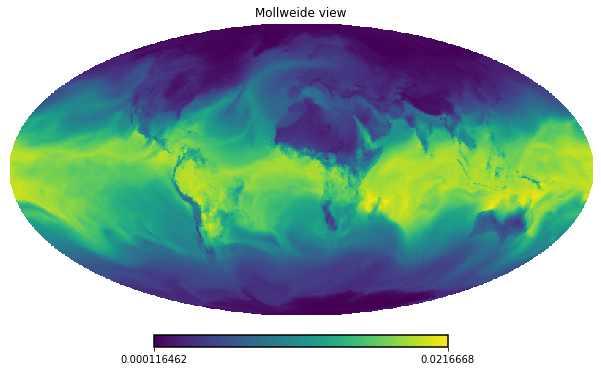

In [6]:
fig = plt.figure(figsize=(12,6), facecolor="white")
healpy.mollview(ds.hus.isel(level_full=-1).isel(time=1), flip="geo", nest=True)

In [15]:
WEST_BOUND = -170
EAST_BOUND =  -60
LAT = -10

def get_nest(ds):
    return ds.crs.healpix_order == "nest"

def get_nside(ds):
    return ds.crs.healpix_nside


points = healpy.ang2vec([WEST_BOUND, WEST_BOUND, EAST_BOUND, EAST_BOUND], 
                        [LAT-1e-5, LAT+1e-5, LAT+1e-5, LAT-1e-5], lonlat=True)
cells  = healpy.query_polygon(get_nside(ds), points, inclusive=True, nest=get_nest(ds))
lons, lats = healpy.pix2ang(get_nside(ds), cells, nest=get_nest(ds), lonlat=True)
lons = (lons+180) % 360 - 180
reorder = np.argsort(lons)
lons = lons[reorder]
cells = xr.DataArray(cells[reorder], coords=[("lon", lons)])

In [16]:
def set_ticks(ax):
    TOP_HEIGHT = 60
    ax.set_yticks(np.arange(TOP_HEIGHT, 90, 2))
    ax.set_yticklabels(zg[TOP_HEIGHT:90:2].astype(int))
    ax.set_ylim(90, TOP_HEIGHT)
    ax.set_ylabel('Height (m)')

In [17]:
# time_label = pd.date_range("2020-01-21", periods=6, freq='1D') - pd.DateOffset(days=10)
time_label = pd.date_range("2020-01-21", periods=6, freq='1D')

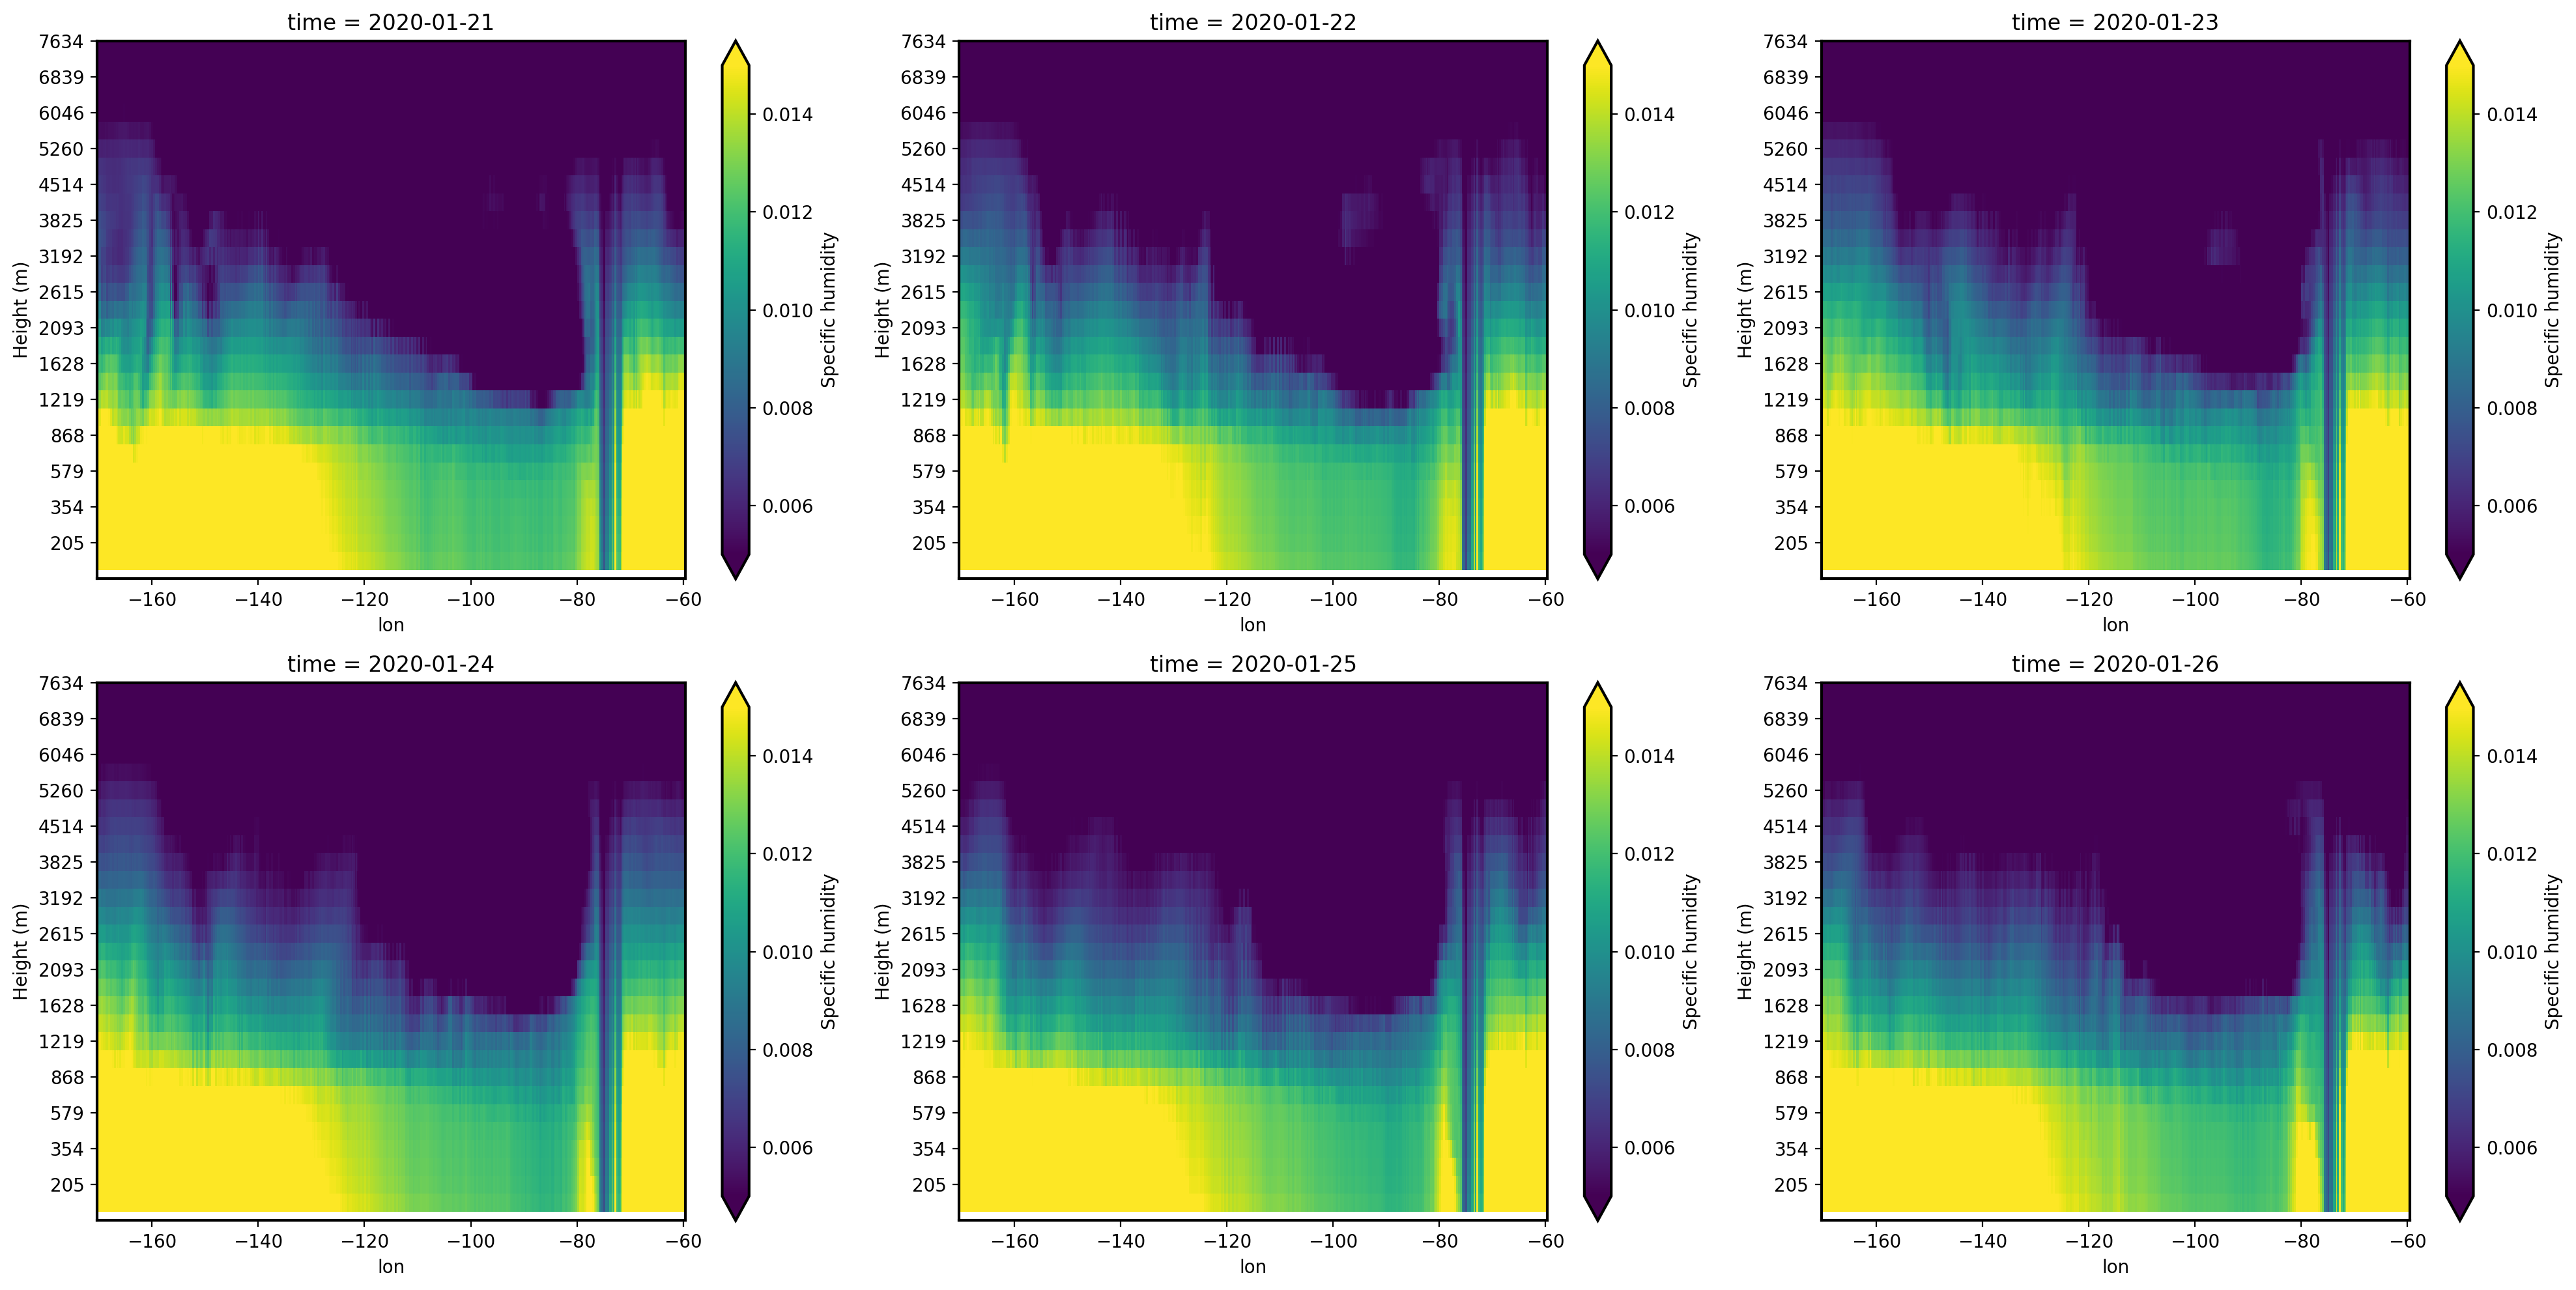

In [18]:
var = 'hus'

rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        # print(time_label[cc + 3*rr])
        img = ds[var].sel(time=time_label[cc + 3*rr]).isel(cell=cells).plot(ax=ax[rr,cc], x="lon", vmin=0.005, vmax=0.015)
        set_ticks(ax[rr,cc])

plt.tight_layout()

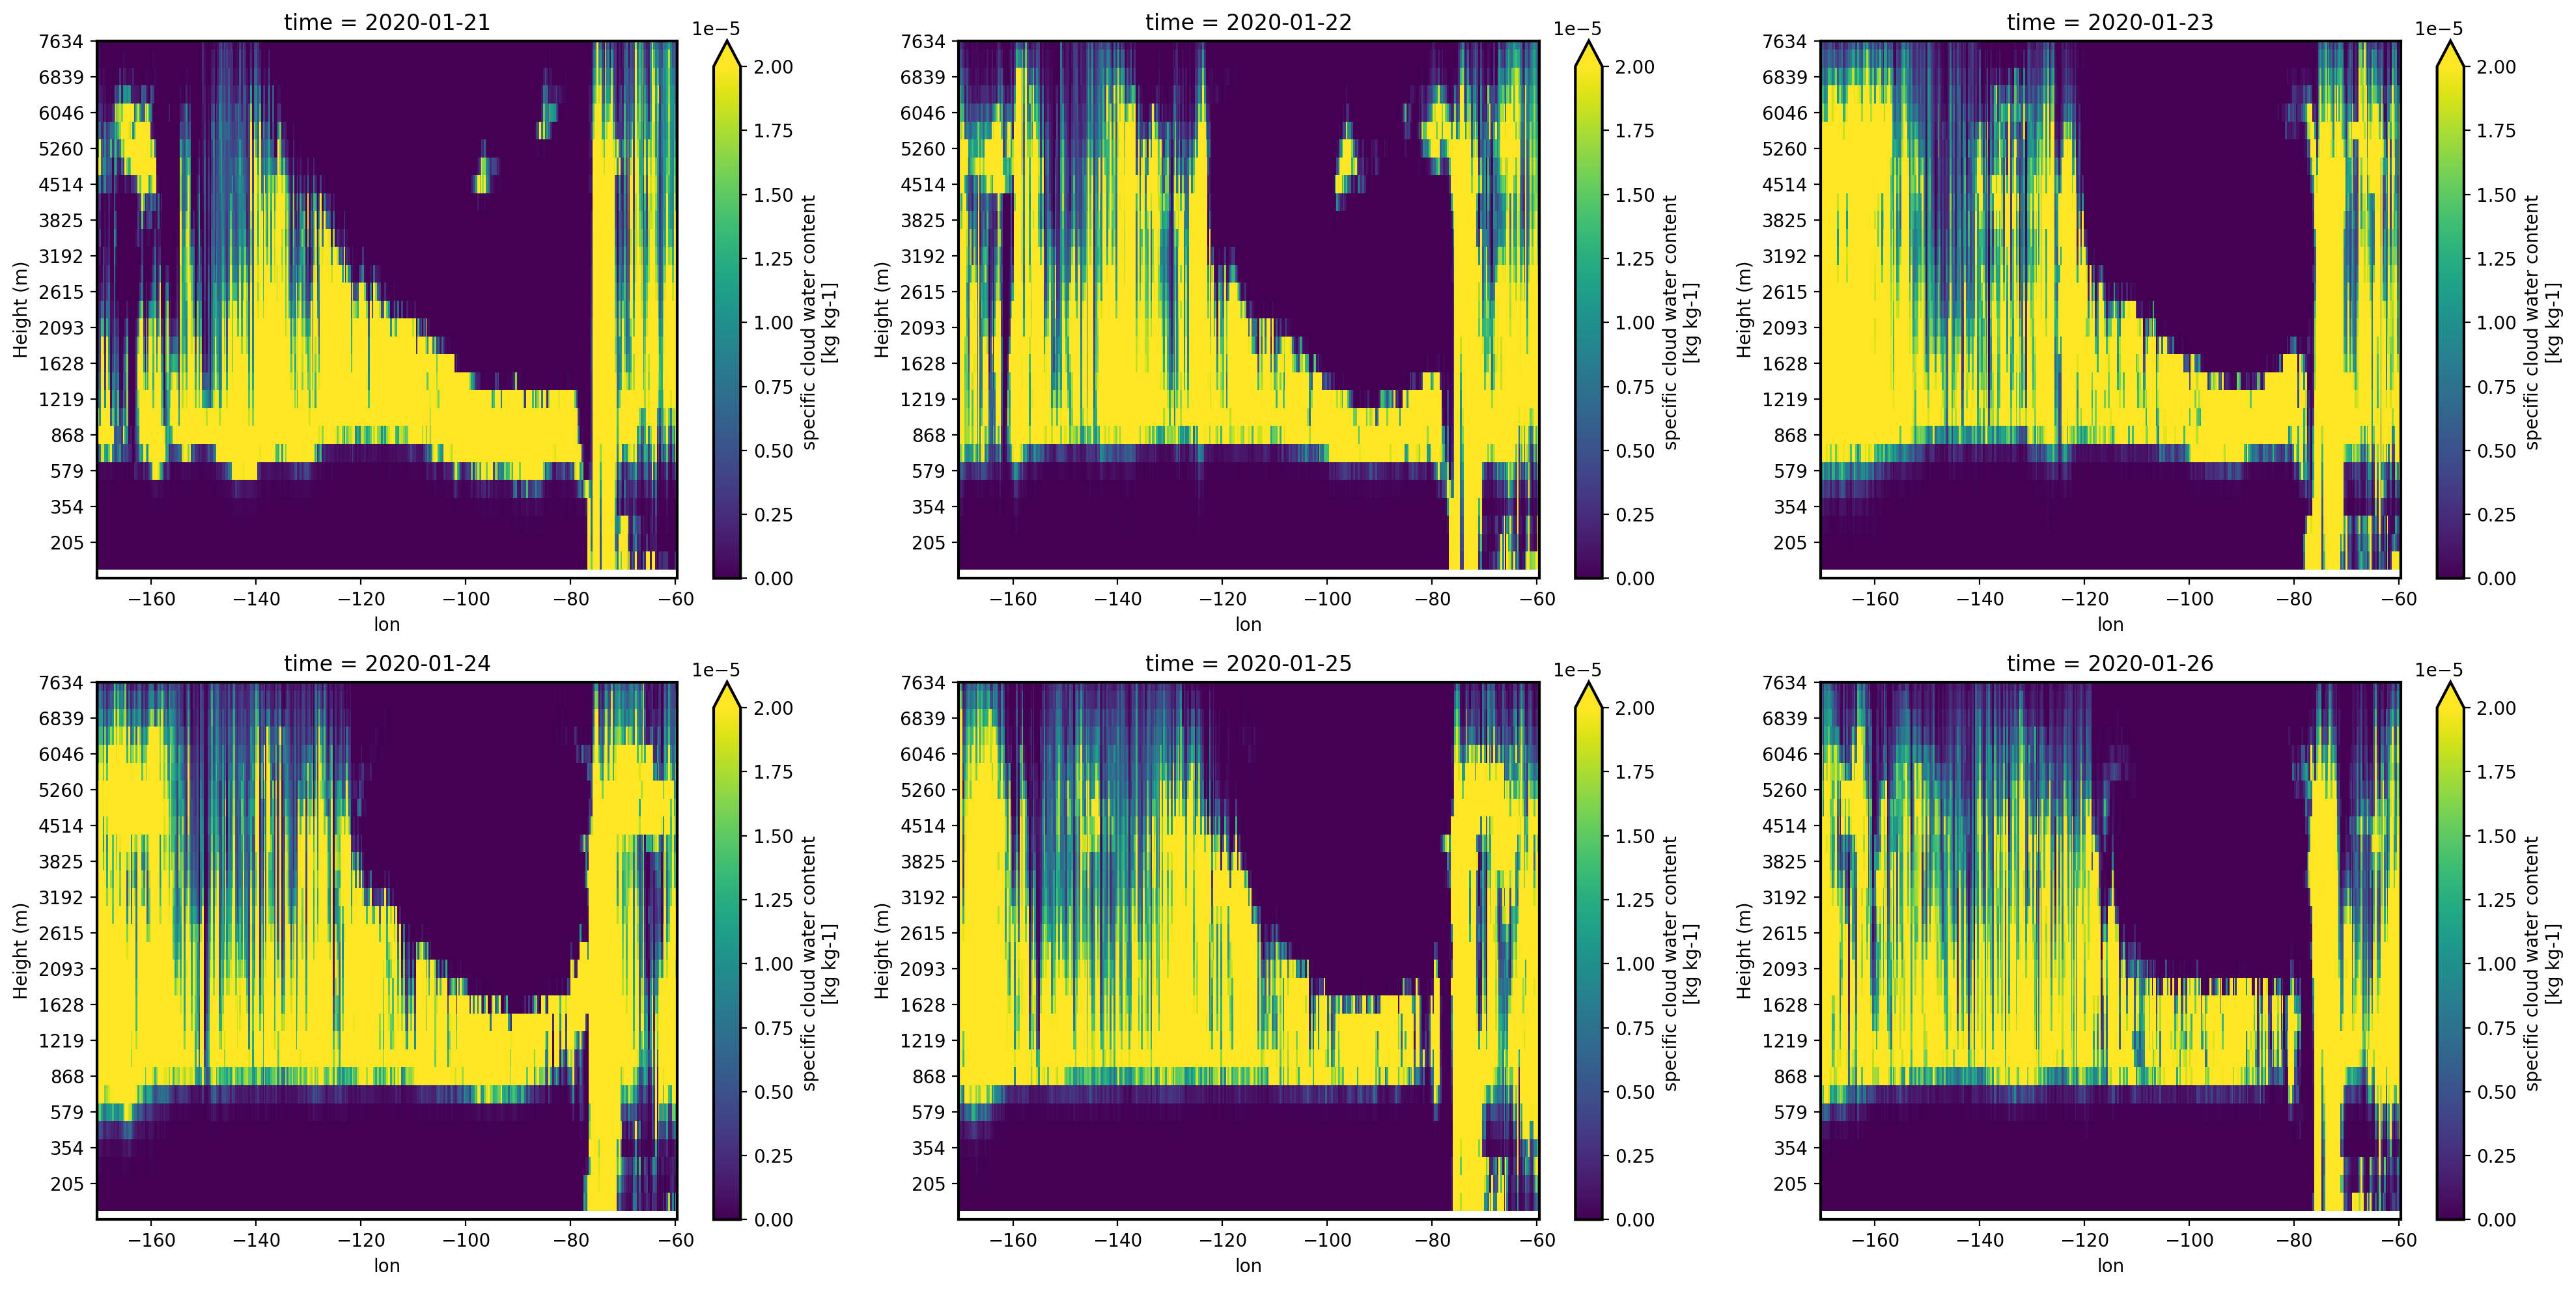

In [19]:
var = 'clw'

rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        # print(time_label[cc + 3*rr])
        img = ds[var].sel(time=time_label[cc + 3*rr]).isel(cell=cells).plot(ax=ax[rr,cc], x="lon", vmin=0, vmax=0.2e-4)
        set_ticks(ax[rr,cc])

plt.tight_layout()

How to compute $\theta_e$:


$$
\theta_e = T * (P_0/P)^{R_d/c_{pd}} * \text{EXP} \left[ \frac{L_v/c_{pd} * q_v}{T*(1-q_v)} \right]
$$

where $L_v$ = 2.5008e6,
$c_{pd}$ = 1004.64,
$R_d$ = 287.04,
$P_0$ = 100000.

In [20]:
Lv  = 2.5008e6
cpd = 1004.64
Rd  = 287.04
Rv  = 461.51
P0  = 100000
Rd_o_cpd = Rd/cpd
vtmpc1 = Rv/Rd-1

P  = ds['pfull']
T  = ds['ta']
qv = ds['hus']
px = ds['cli'] + ds['clw']

theta   = T * (P0/P)**(Rd_o_cpd)
theta_v = T * (P0/P)**(Rd_o_cpd) * (1 + vtmpc1*qv - px)
theta_e = T * (P0/P)**(Rd_o_cpd) * np.exp( (qv*Lv/cpd) / (T*(1-qv)) )

In [21]:
def spec_humi(pvap, pres):
    rdv = 287.04/461.51
    o_m_rdv = 1 - rdv
    
    spec_humi = rdv*pvap/( pres - o_m_rdv*pvap )
    return spec_humi

def sat_pres_water(temp):
    
    b1 = 610.78
    b2w = 17.269
    b3 = 273.15
    b4w = 35.86
    
    sat_press = b1 * np.exp( b2w * (temp-b3)/(temp-b4w) )
    return sat_press

hur = qv / spec_humi(sat_pres_water(T), P)

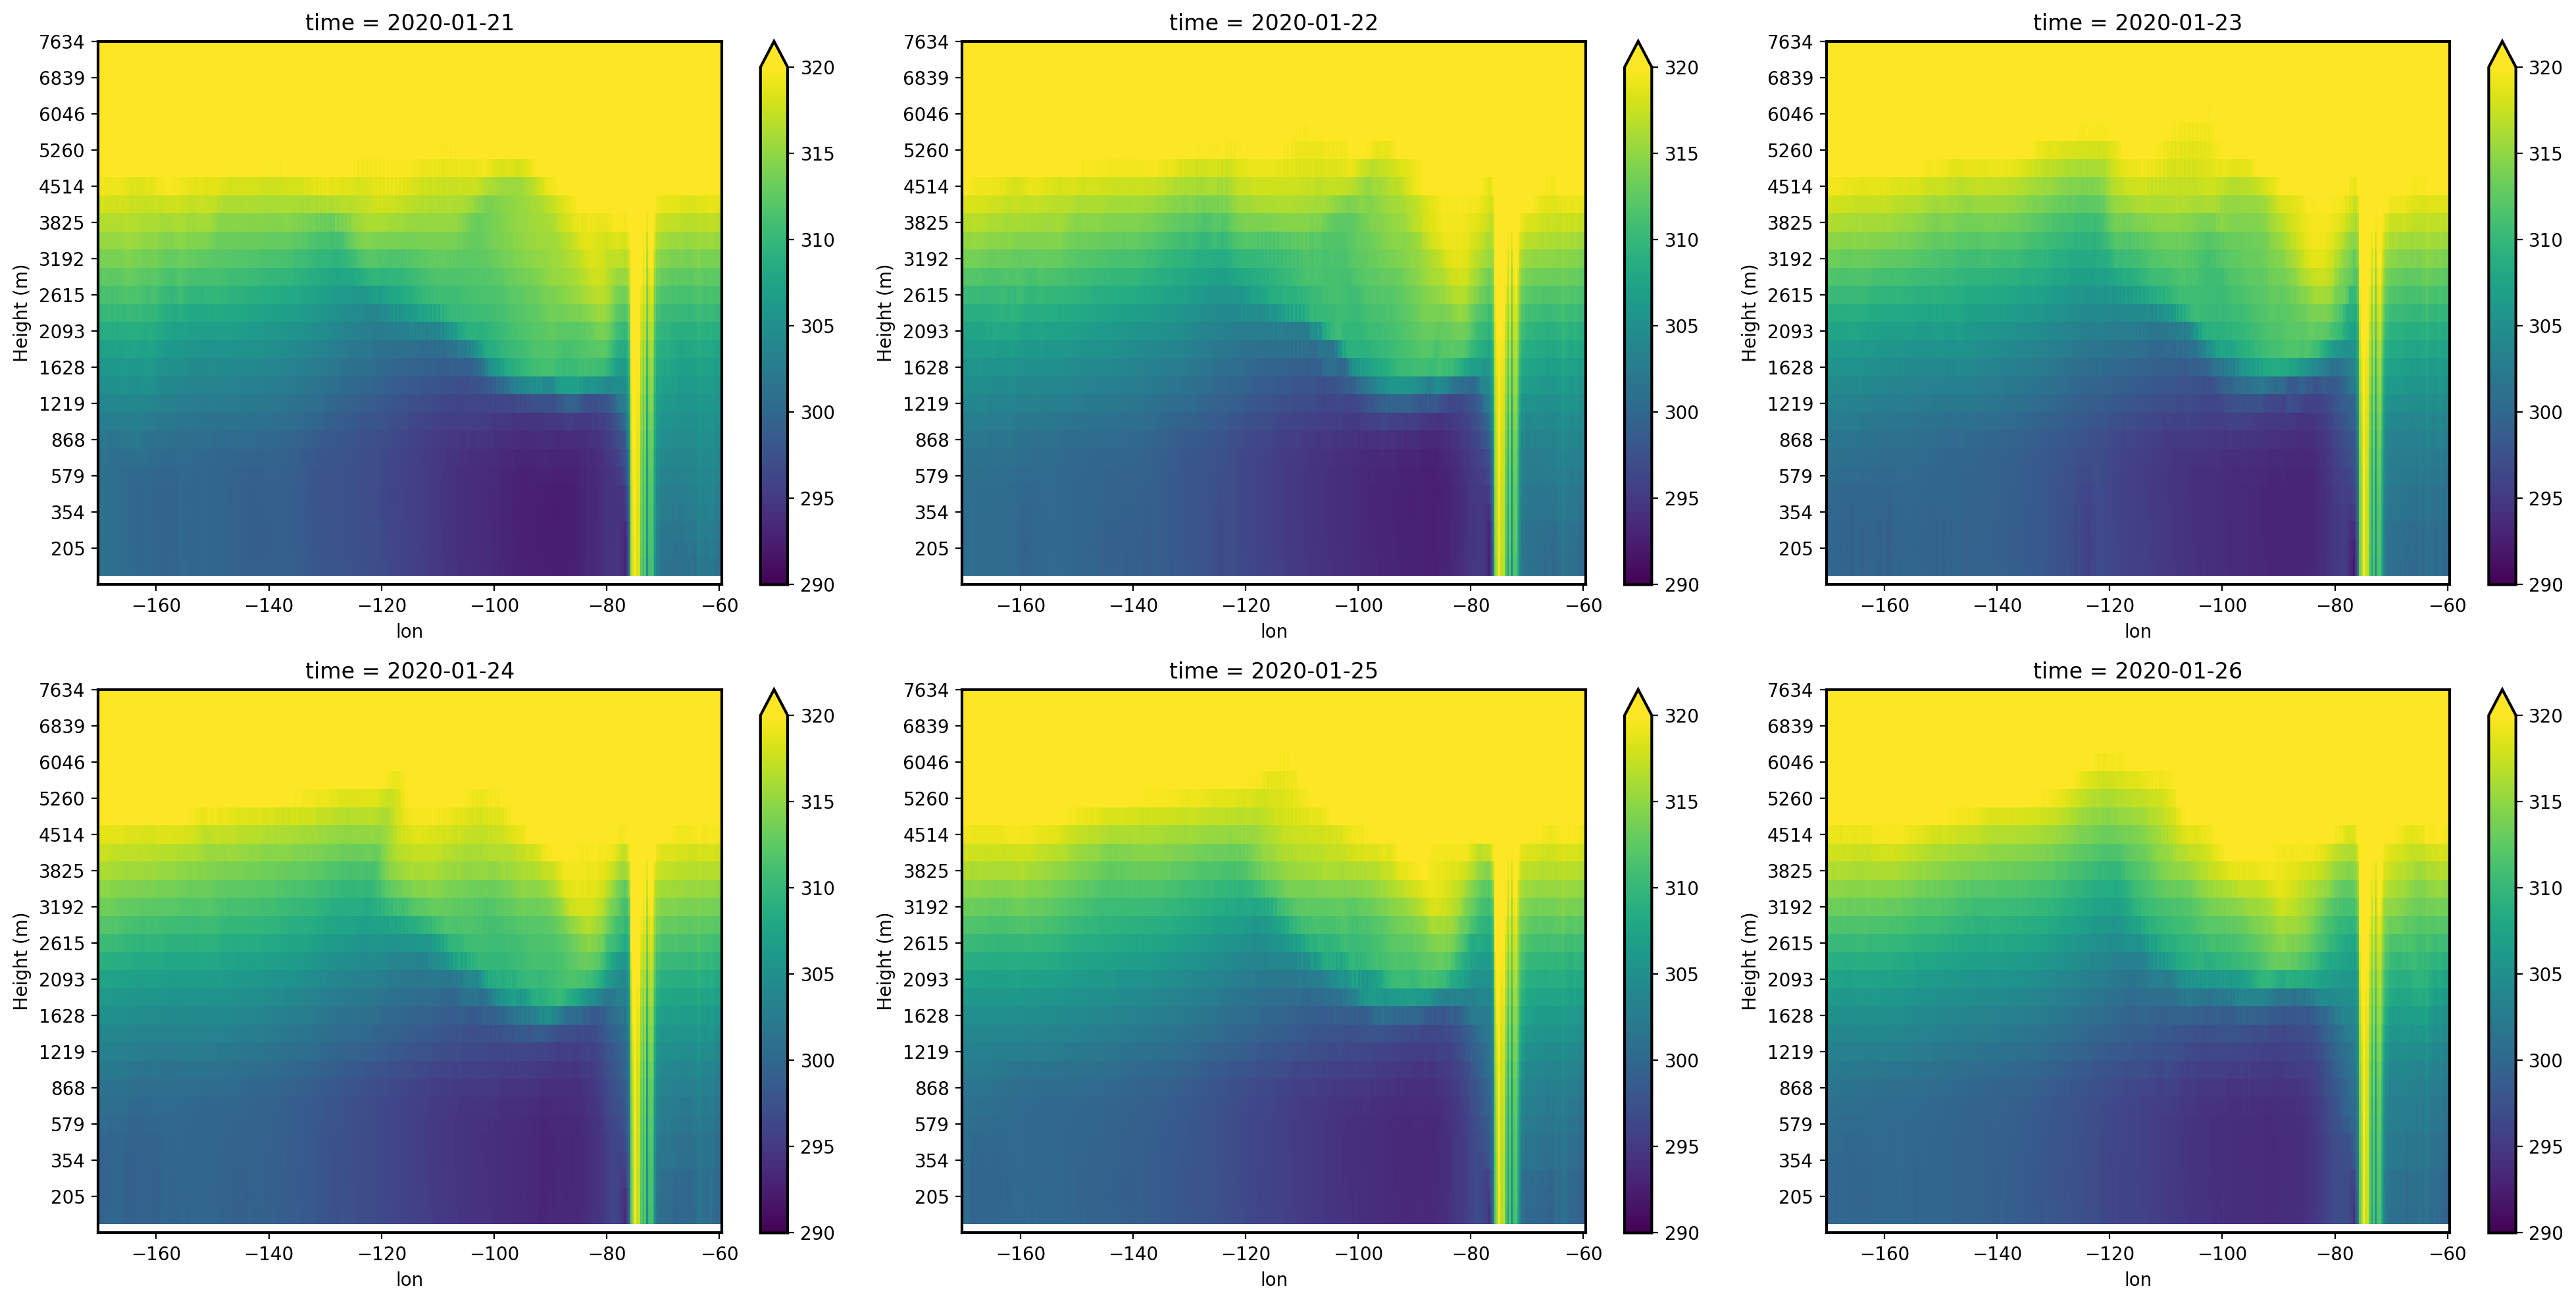

In [22]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        # print(time_label[cc + 3*rr])
        img = theta.sel(time=time_label[cc + 3*rr]).isel(cell=cells).plot(ax=ax[rr,cc], x="lon", vmin=290, vmax=320)
        set_ticks(ax[rr,cc])

plt.tight_layout()

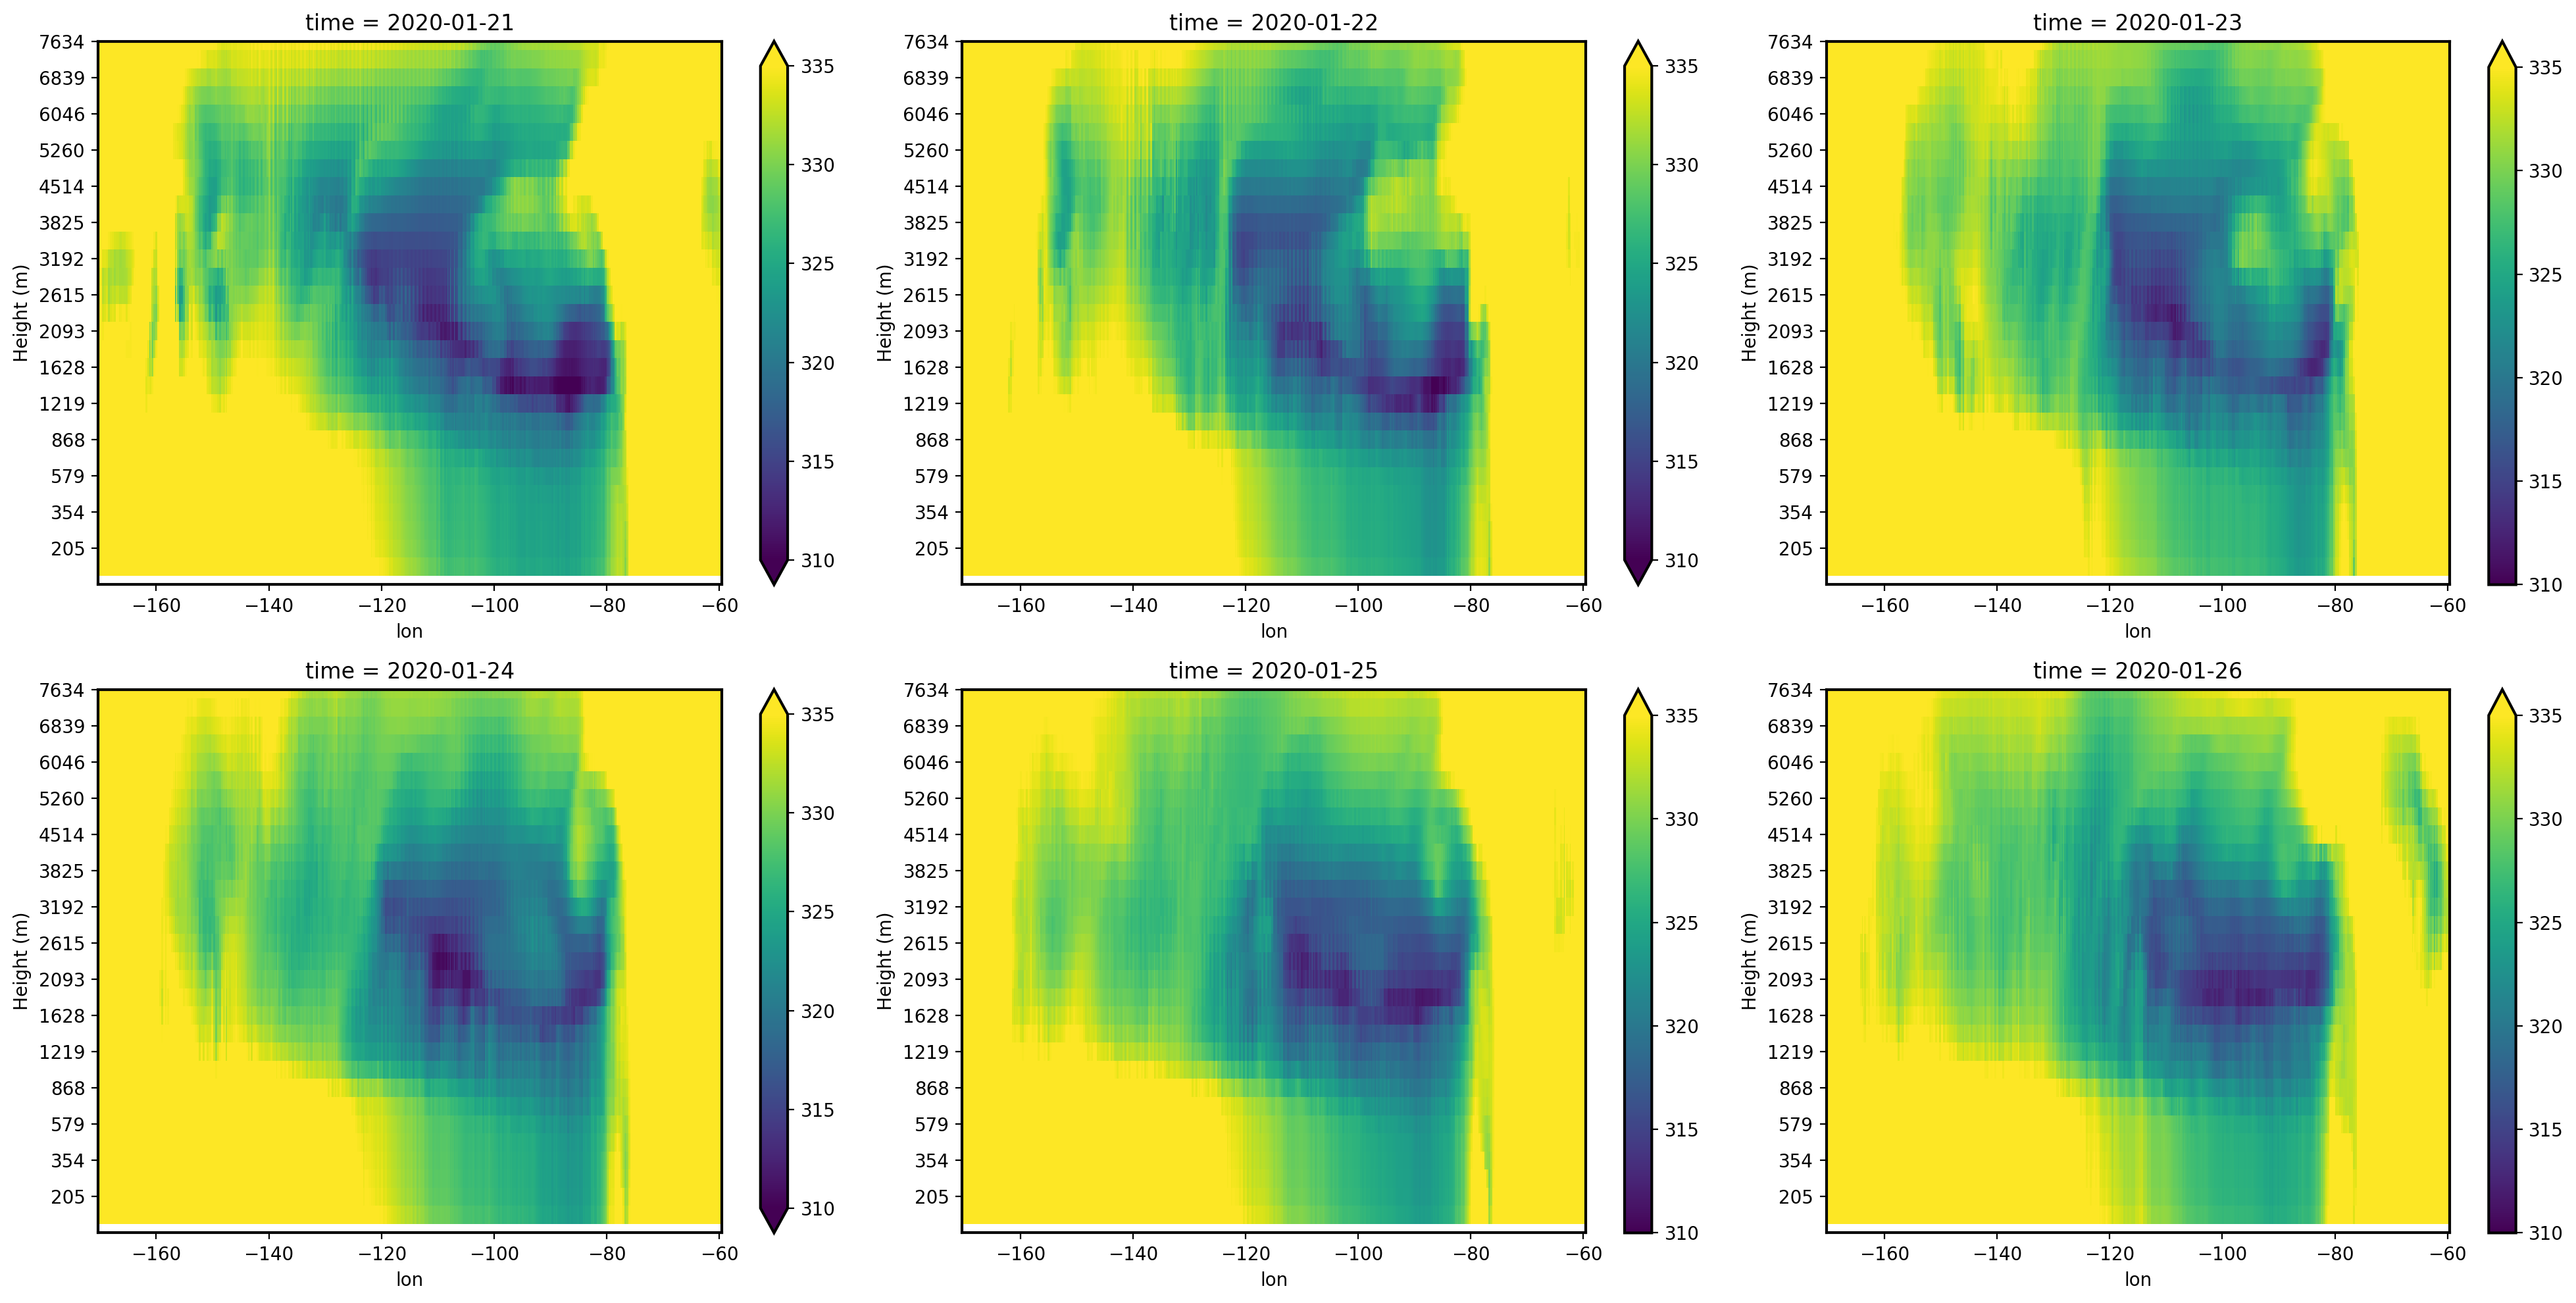

In [23]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        img = theta_e.sel(time=time_label[cc + 3*rr]).isel(cell=cells).plot(ax=ax[rr,cc], x="lon", vmin=310, vmax=335)
        set_ticks(ax[rr,cc])

plt.tight_layout()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


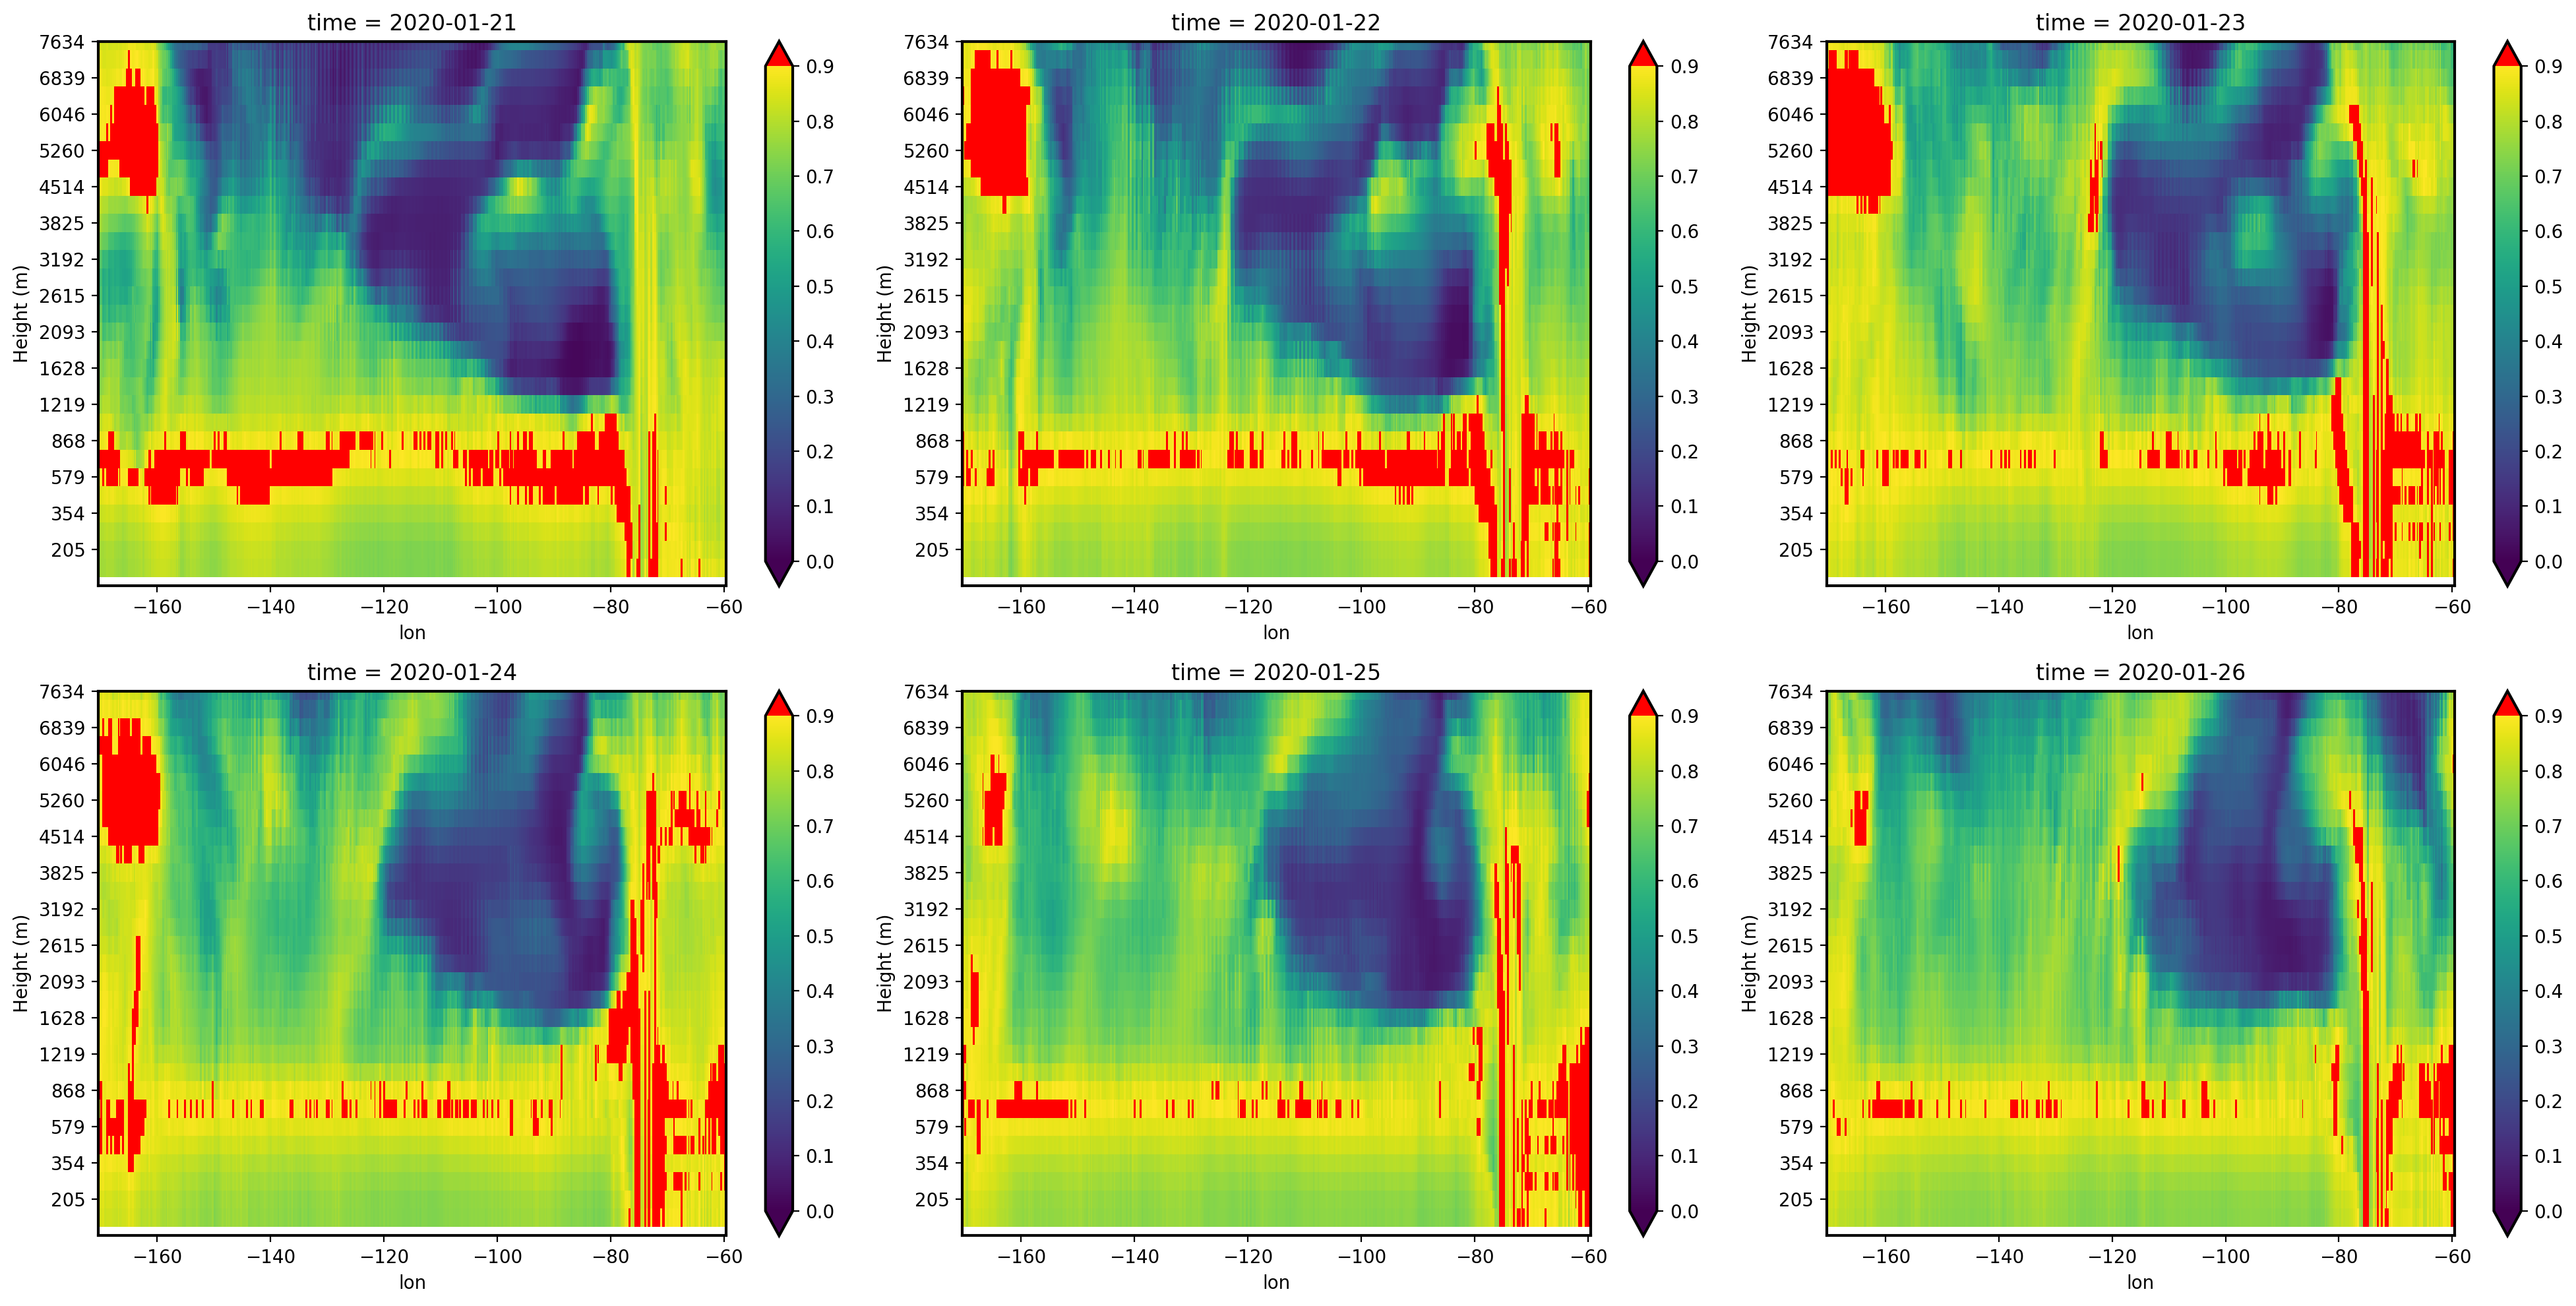

In [24]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

cmap1 = mpl.cm.get_cmap("viridis").copy()
cmap1.set_over('red')

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        # print(time_label[cc + 3*rr])
        img = hur.sel(time=time_label[cc + 3*rr]).isel(cell=cells).plot(ax=ax[rr,cc], x="lon", cmap=cmap1, vmin=0, vmax=.9)
        set_ticks(ax[rr,cc])

plt.tight_layout()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


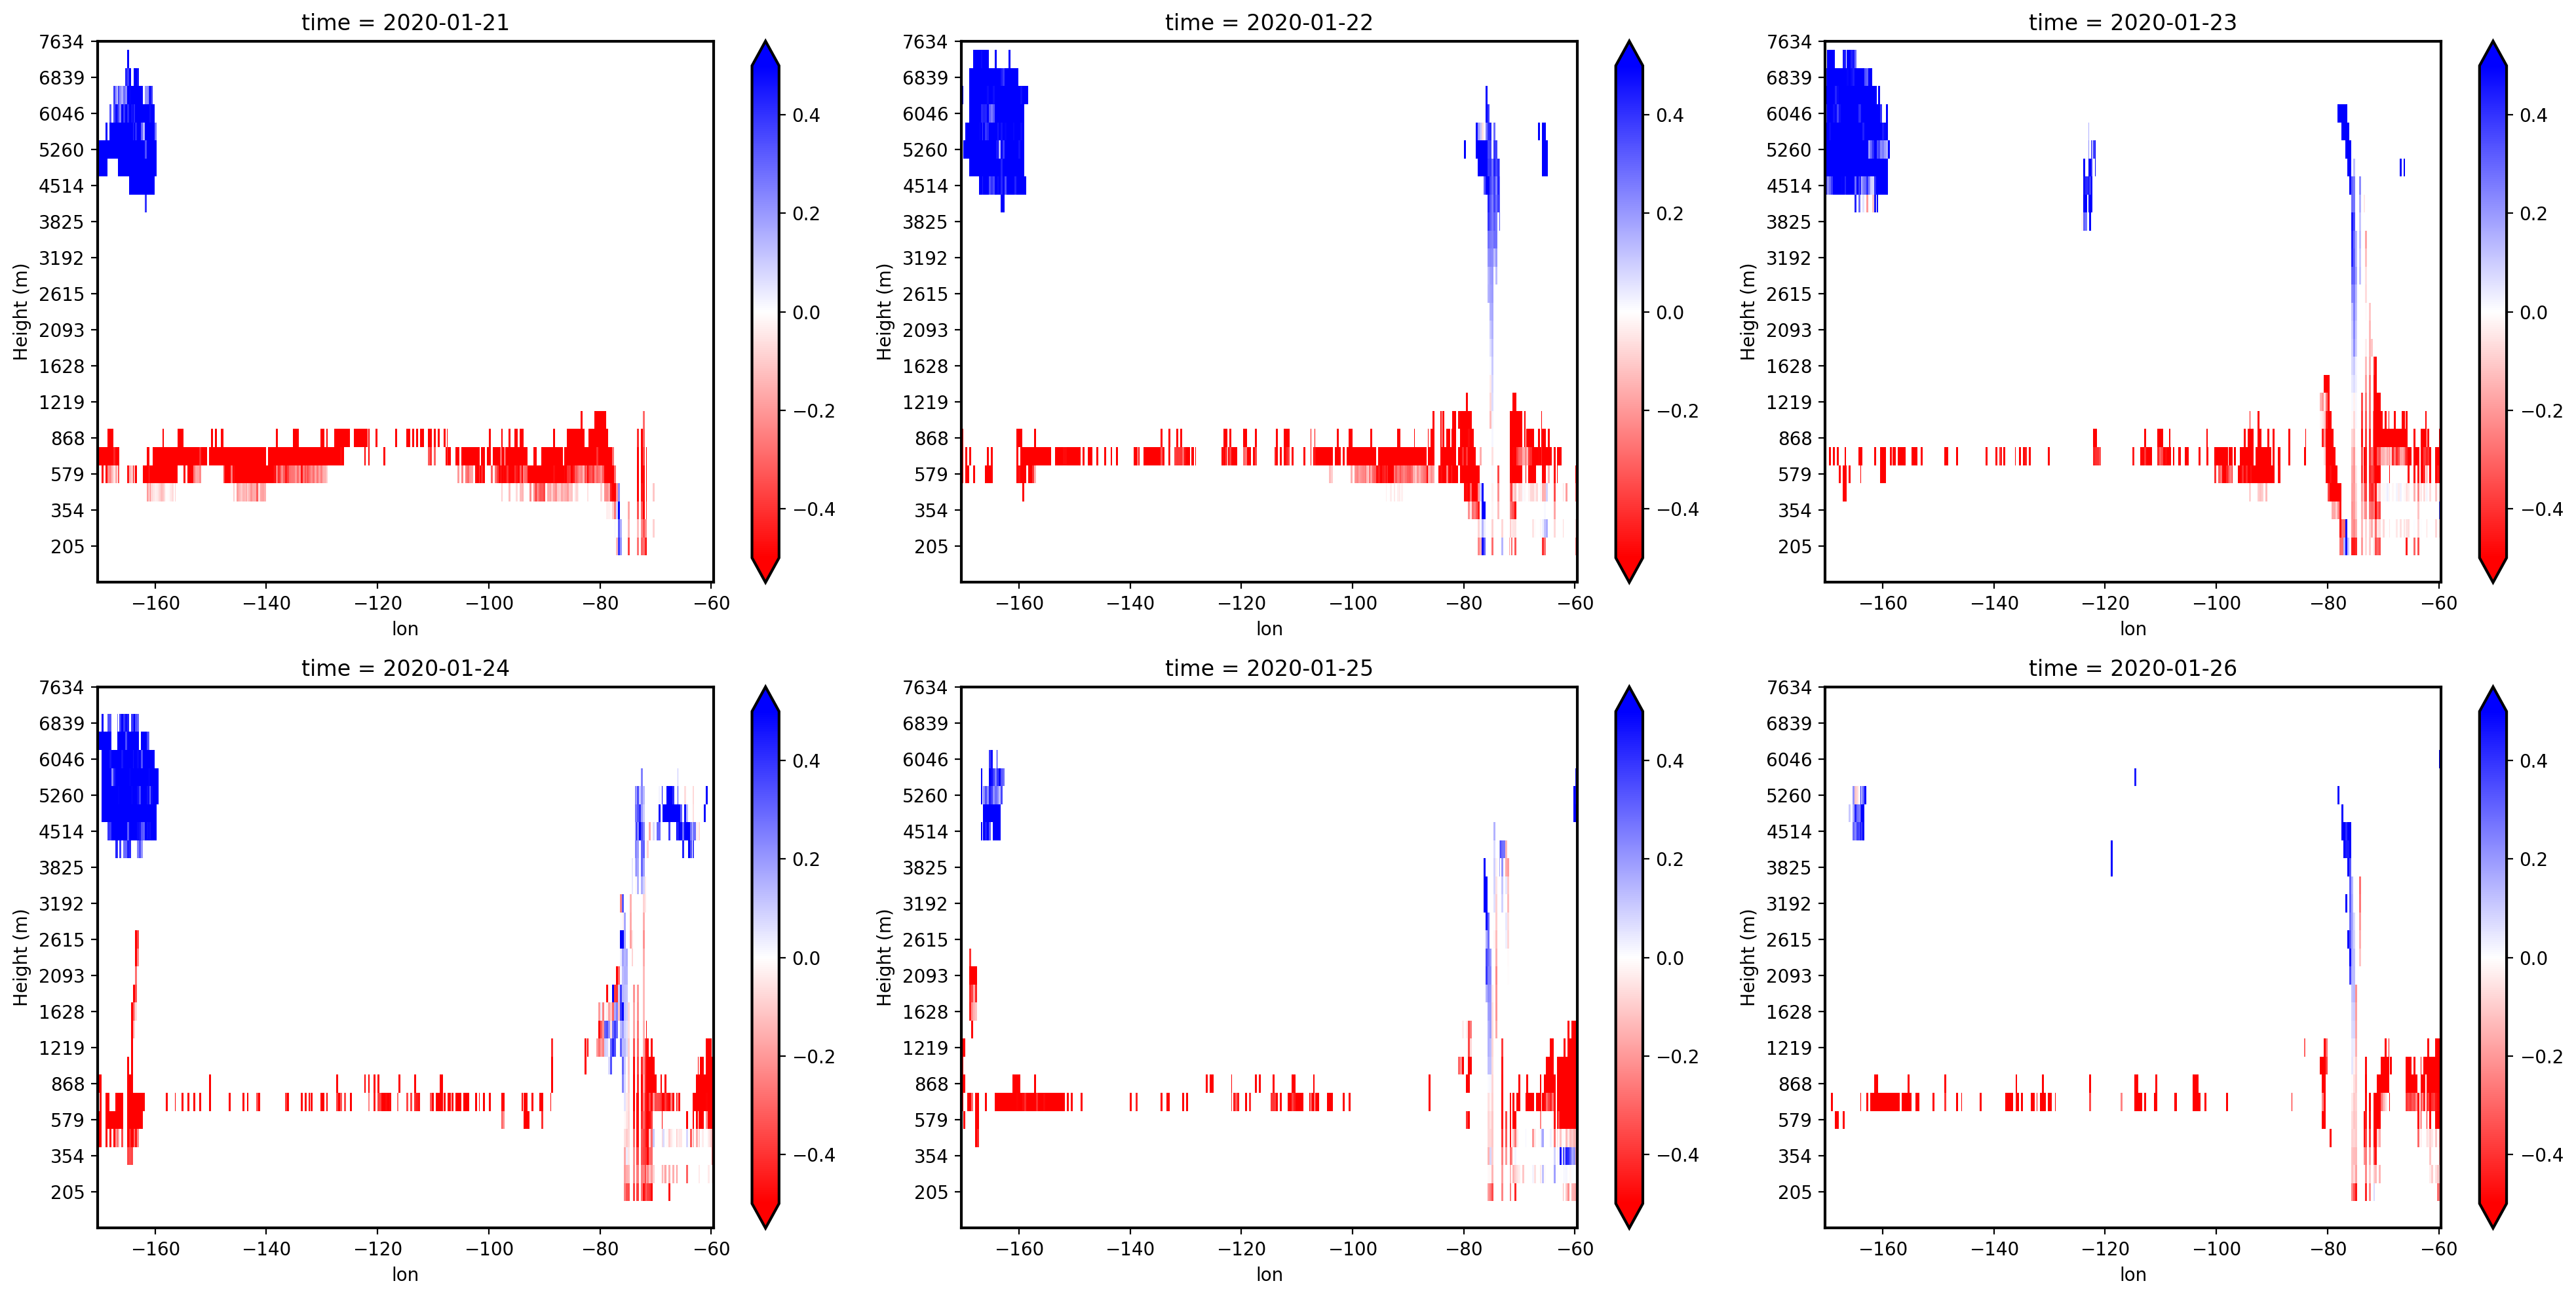

In [25]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

theta_e_diff = theta_e * -1.

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        
        mask = hur.sel(time=time_label[cc + 3*rr]).isel(cell=cells, level_full=slice(0,89))
        img = theta_e_diff.diff('level_full').sel(time=time_label[cc + 3*rr]).isel(cell=cells).where(mask>0.9). \
              plot(ax=ax[rr,cc], x="lon", cmap=cm.bwr_r, vmin=-0.5, vmax=0.5)
        set_ticks(ax[rr,cc])

plt.tight_layout()

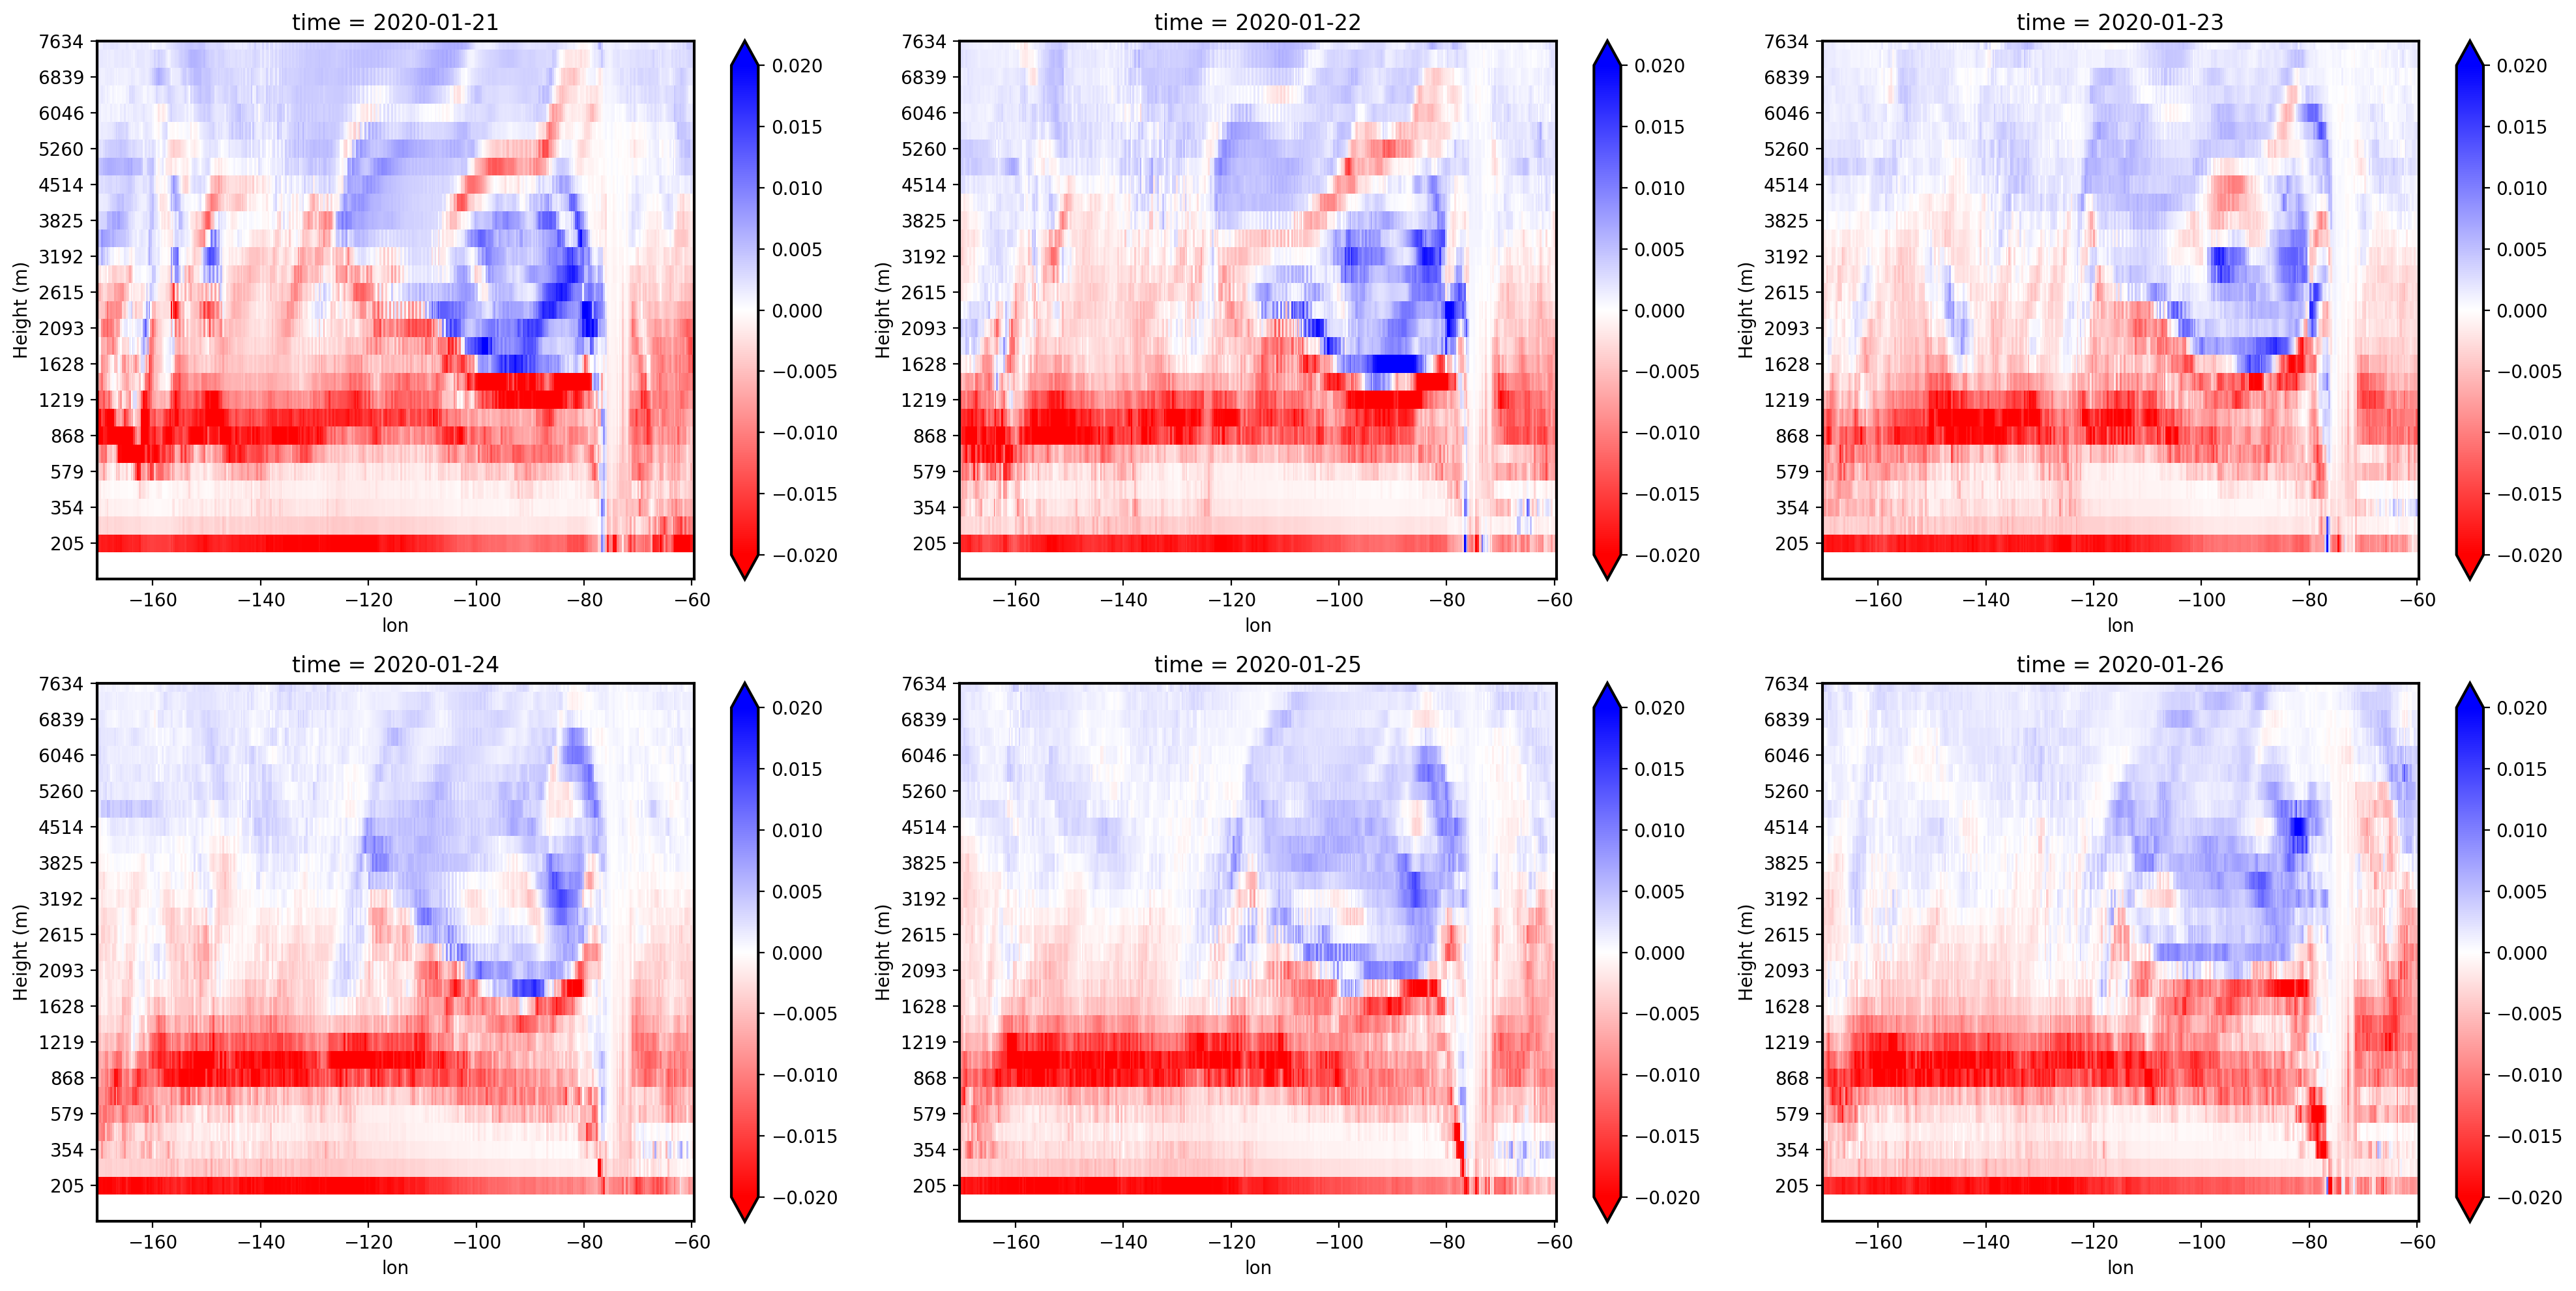

In [26]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

theta_e_diff = theta_e * -1.
dz = np.diff(zg) * -1.
dtheta_e_dz = theta_e_diff.diff('level_full') / dz.reshape((1,89,1)) 

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        
        # img = theta_e_diff.diff('level_full').sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
        img = dtheta_e_dz.sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
              plot(ax=ax[rr,cc], x="lon", cmap=cm.bwr_r, vmin=-0.02, vmax=0.02)
        set_ticks(ax[rr,cc])

plt.tight_layout()

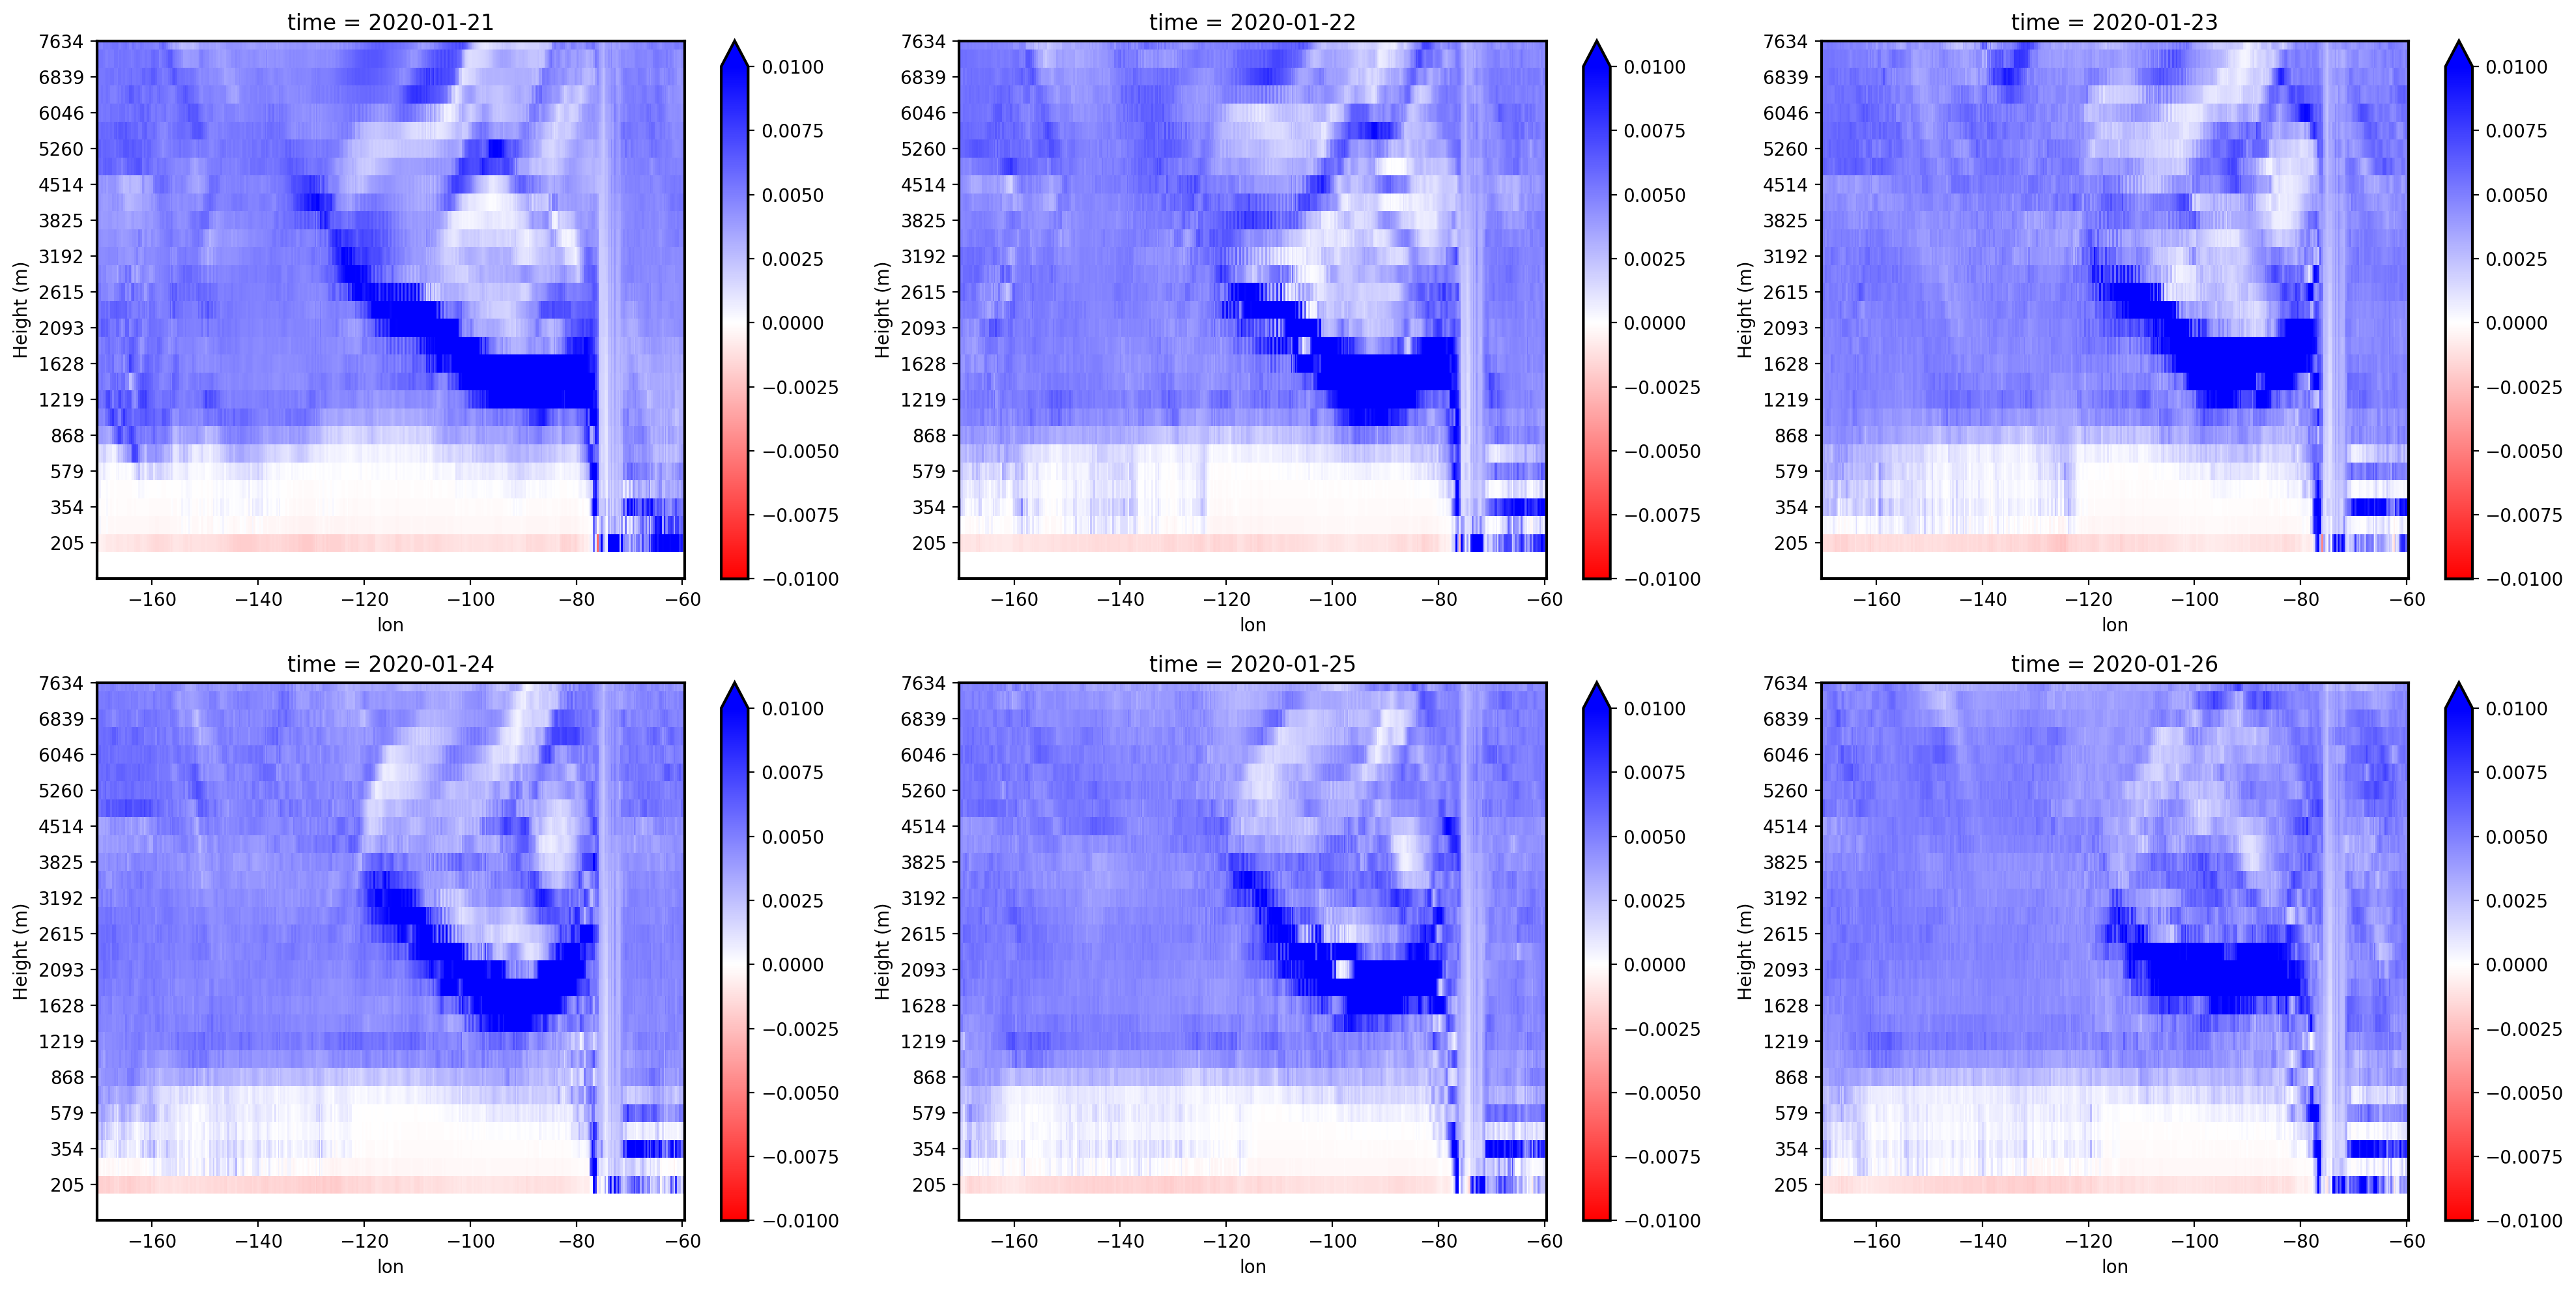

In [27]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

theta_diff = theta * -1.
dz = np.diff(zg) * -1.
dtheta_dz = theta_diff.diff('level_full') / dz.reshape((1,89,1)) 

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        
        # img = theta_e_diff.diff('level_full').sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
        img = dtheta_dz.sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
              plot(ax=ax[rr,cc], x="lon", cmap=cm.bwr_r, vmin=-0.01, vmax=0.01)
        set_ticks(ax[rr,cc])

plt.tight_layout()

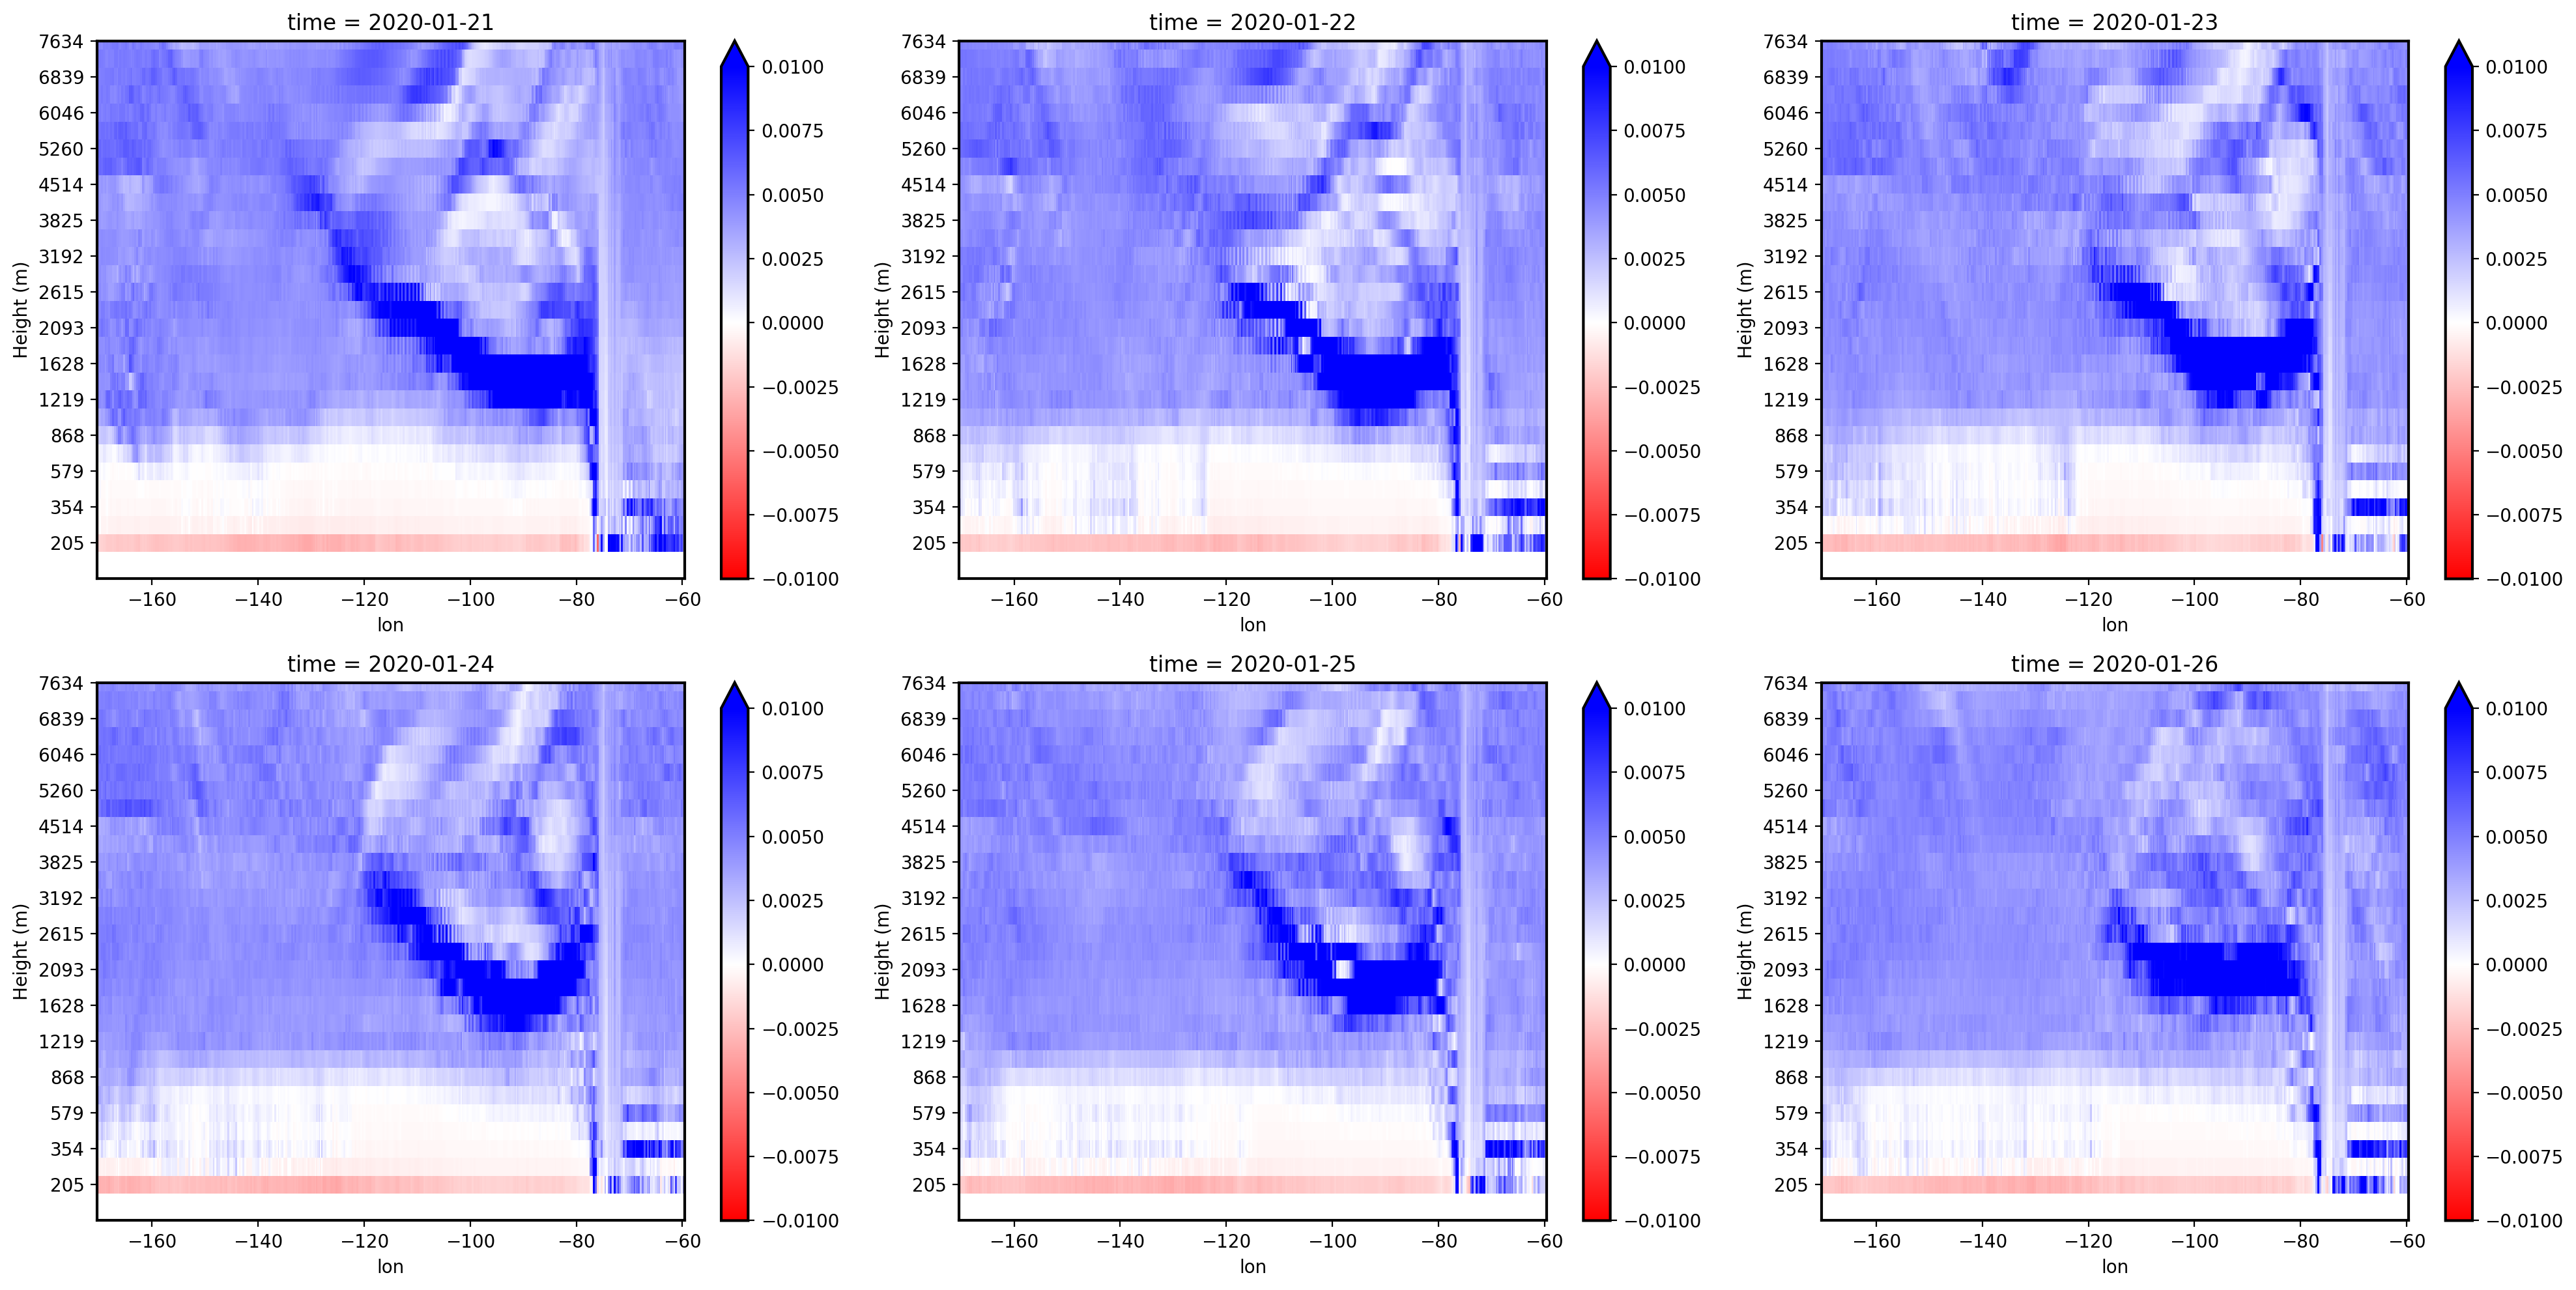

In [28]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)

theta_v_diff = theta_v * -1.
dz = np.diff(zg) * -1.
dtheta_v_dz = theta_v_diff.diff('level_full') / dz.reshape((1,89,1)) 

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        
        # img = theta_e_diff.diff('level_full').sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
        img = dtheta_v_dz.sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
              plot(ax=ax[rr,cc], x="lon", cmap=cm.bwr_r, vmin=-0.01, vmax=0.01)
        set_ticks(ax[rr,cc])

plt.tight_layout()


### Richardson number

$$
Ri = \frac{N^2}{S^2}
$$

$$
N^2 = \frac{g}{\theta_v} \frac{\Delta \theta_v}{\Delta z}
$$

$$
S^2 = \frac{(\Delta U)^2 + (\Delta V)^2}{(\Delta z)^2}
$$

In [29]:
U  = ds['ua']
V  = ds['va']

U_diff = U * -1.
V_diff = V * -1.
dz = np.diff(zg) * -1.
dU = U_diff.diff('level_full')
dV = V_diff.diff('level_full')

In [31]:
dtheta_v_dz

<xarray.DataArray (time: 370, level_full: 89, cell: 196608)>
dask.array<truediv, shape=(370, 89, 196608), dtype=float64, chunksize=(2, 59, 196608), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2021-01-24
Dimensions without coordinates: level_full, cell

In [32]:
theta_v

<xarray.DataArray (time: 370, level_full: 90, cell: 196608)>
dask.array<mul, shape=(370, 90, 196608), dtype=float64, chunksize=(2, 60, 196608), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2021-01-24
Dimensions without coordinates: level_full, cell

In [36]:
grav = 9.80665

N2 = grav/theta_v.isel(level_full=slice(0,89)) * dtheta_v_dz
S2 = (dU**2 + dV**2) / dz.reshape((1,89,1))**2
Ri = N2/S2

In [47]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcamp'):
    '''
    '''
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

/tmp/ipykernel_692485/164404218.py:30: UserWarning: Trying to register the cmap 'shifted' which already exists.
  plt.register_cmap(cmap=newcmap)


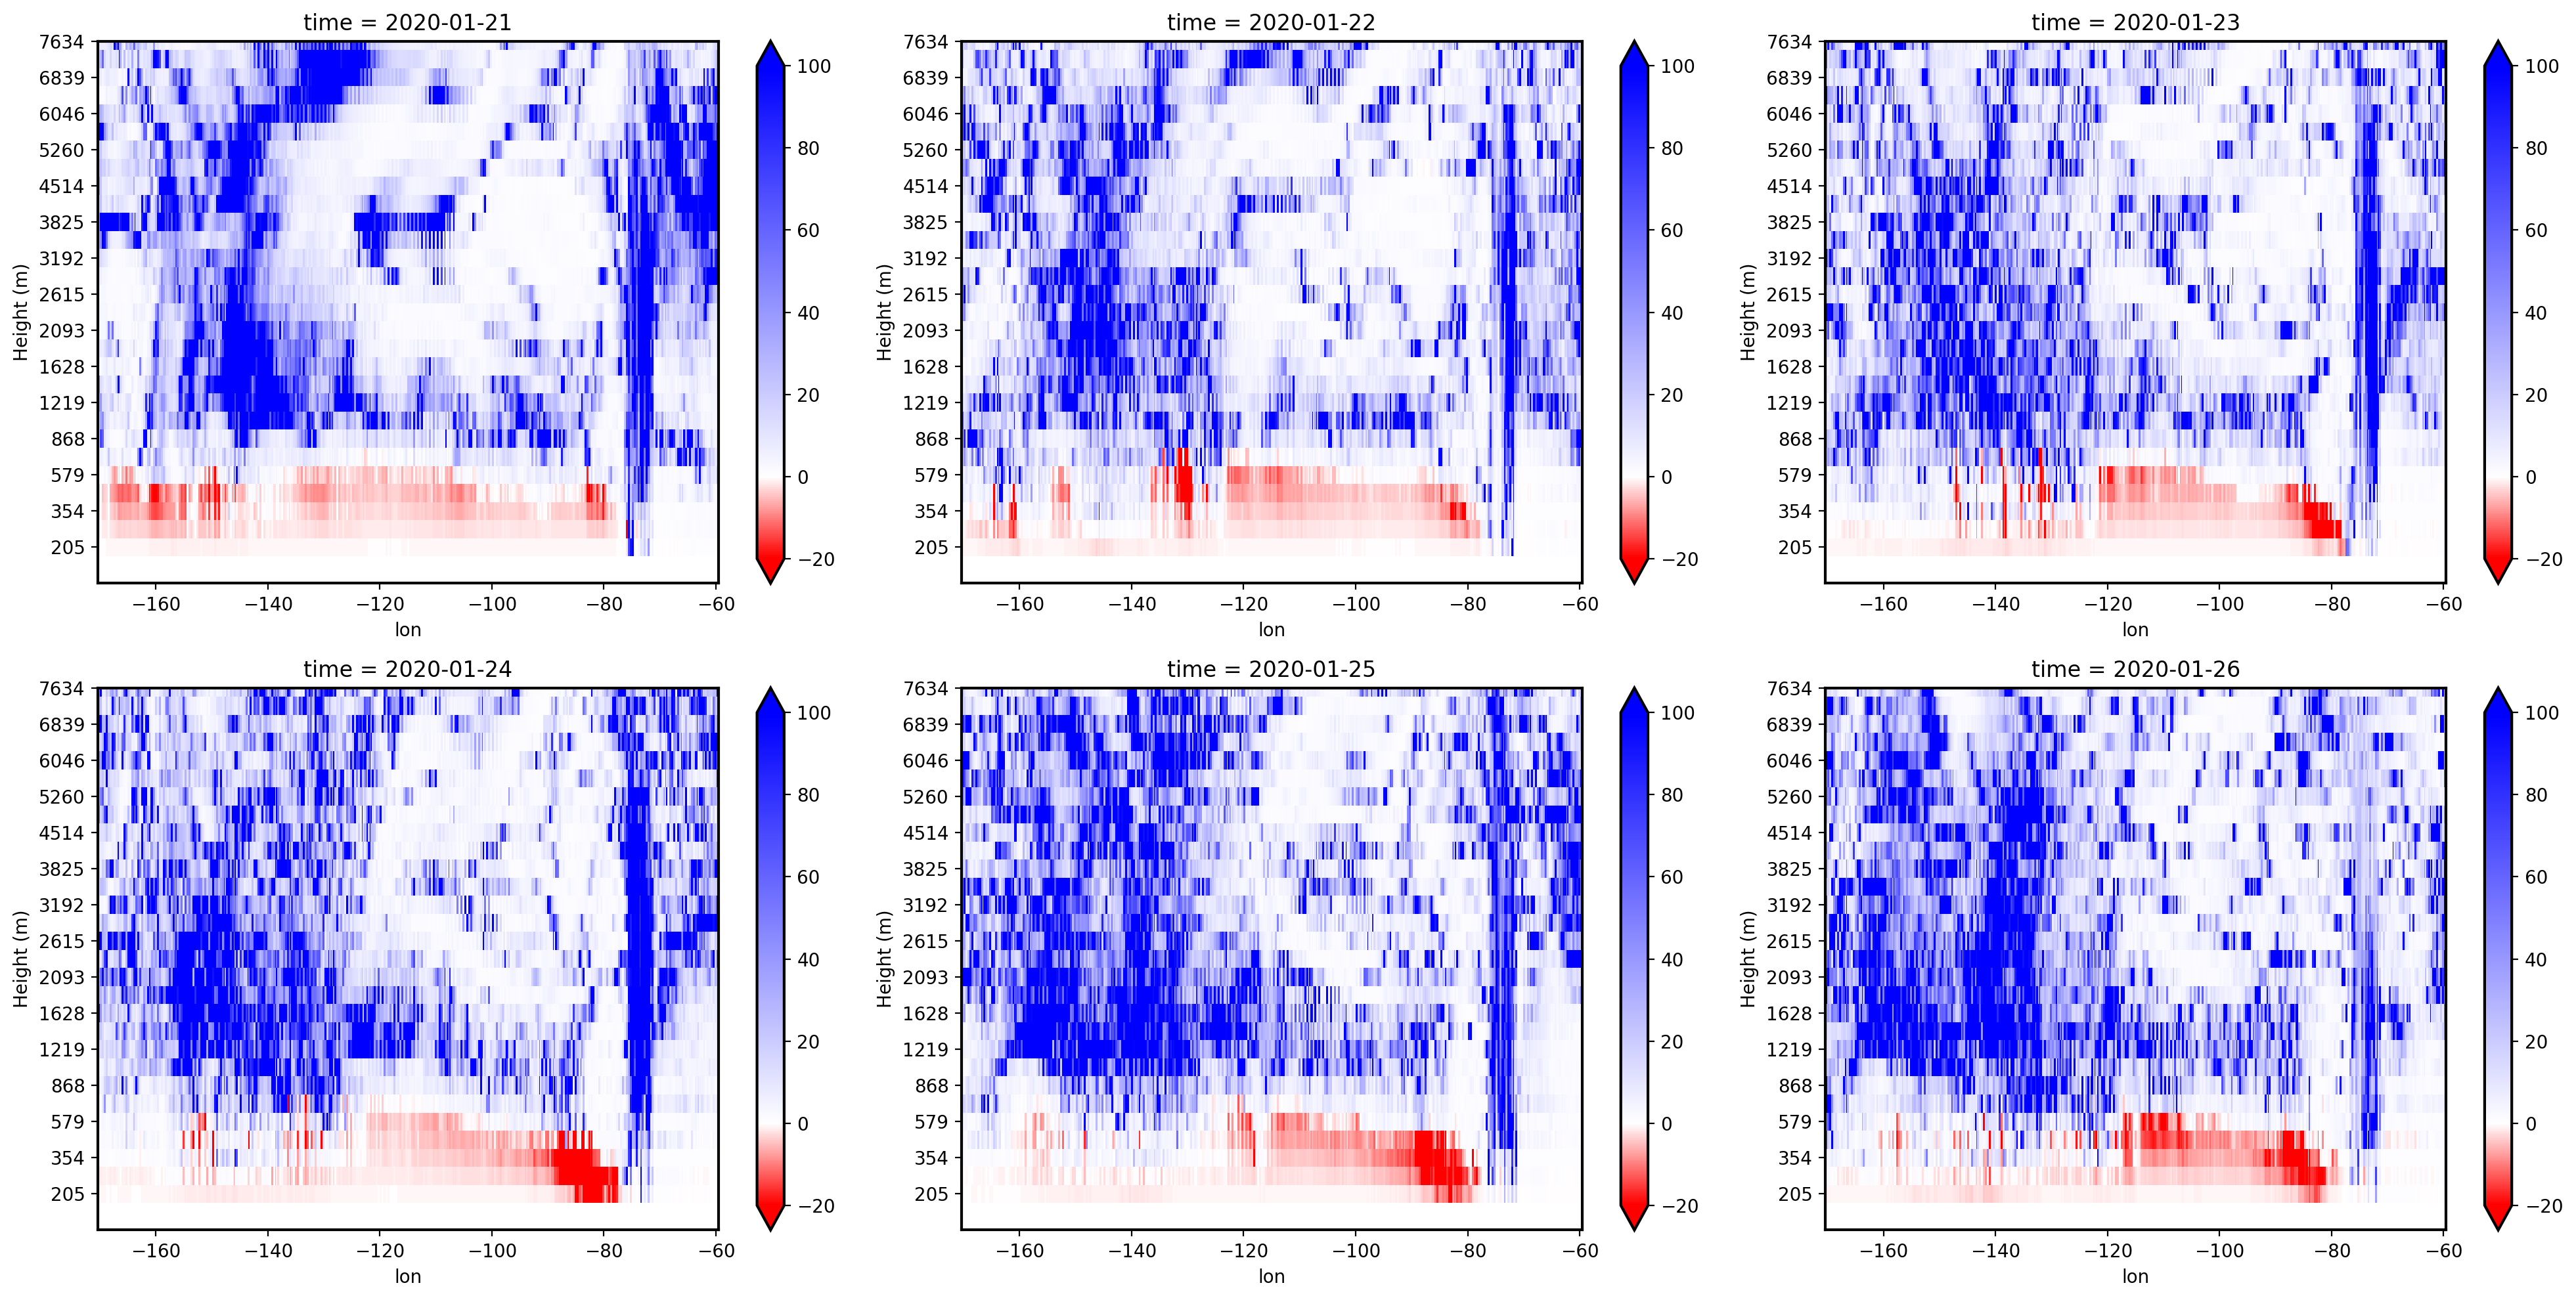

In [52]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10),)
vmin, vmax = -20, 100

shifted_cmap = shiftedColorMap(cm.bwr_r, midpoint=np.abs(vmin)/(vmax+np.abs(vmin)), name='shifted')

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        
        # img = theta_e_diff.diff('level_full').sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
        img = Ri.sel(time=time_label[cc + 3*rr]).isel(cell=cells). \
              plot(ax=ax[rr,cc], x="lon", cmap=shifted_cmap, vmin=vmin, vmax=vmax)
        set_ticks(ax[rr,cc])

plt.tight_layout()

# Area mean profile

In [ ]:
LON_UPPER_BOUND = -170
LON_LOWER_BOUND =  -60
LAT = -10

def get_nest(ds):
    return ds.crs.healpix_order == "nest"

def get_nside(ds):
    return ds.crs.healpix_nside


points = healpy.ang2vec([WEST_BOUND, WEST_BOUND, EAST_BOUND, EAST_BOUND], 
                        [LAT-1e-5, LAT+1e-5, LAT+1e-5, LAT-1e-5], lonlat=True)
cells  = healpy.query_polygon(get_nside(ds), points, inclusive=True, nest=get_nest(ds))
lons, lats = healpy.pix2ang(get_nside(ds), cells, nest=get_nest(ds), lonlat=True)
lons = (lons+180) % 360 - 180
reorder = np.argsort(lons)
lons = lons[reorder]
cells = xr.DataArray(cells[reorder], coords=[("lon", lons)])

In [25]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    var: variable on healpix coordinates (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    kwargs: additional arguments to imshow
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    xyz = ccrs.Geocentric().transform_points(ax.projection, xvals2, yvals2, np.zeros_like(xvals2))
    valid = np.all(np.isfinite(xyz), axis=-1)
    pix = healpy.vec2pix(healpy.npix2nside(len(var)), *xyz[valid].T, nest=True)
    res = np.full(xyz.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims+ylims, origin="lower", **kwargs)

In [79]:
cloud_mixing_flag.values

array([ True,  True,  True, ...,  True,  True,  True])

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


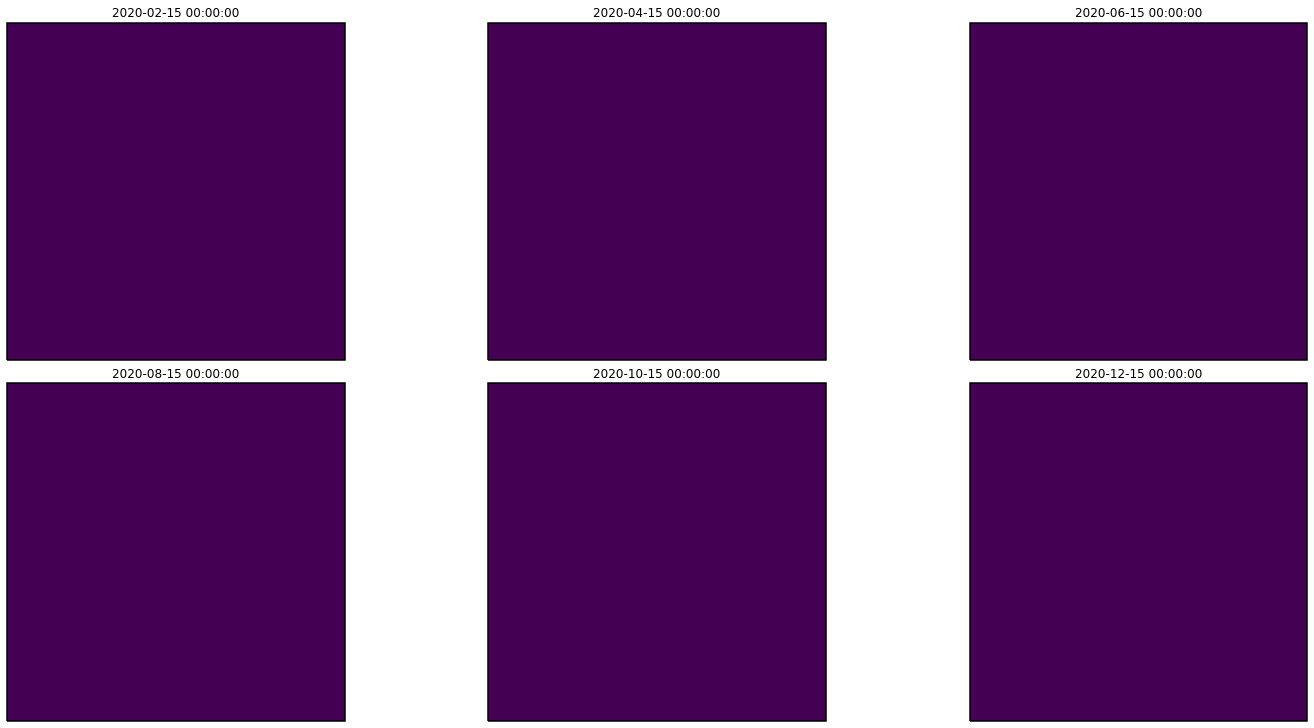

In [84]:
rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20,10), 
                       subplot_kw={"projection": ccrs.Robinson(central_longitude=-135.5808361)},
                       constrained_layout=True)

time_label = pd.date_range("2020-01-01", periods=6, freq='2M') + pd.DateOffset(days=15)
theta_e_diff = theta_e * -1.

for rr in [0, 1]:
    for cc in [0, 1, 2]:
        mask = hur.sel(time=time_label[cc + 3*rr]).isel(level_full=slice(0,89))
        cloud_mixing_flag = theta_e_diff.diff('level_full').sel(time=time_label[rr + 3*rr]).where(mask>0.9)
        cloud_mixing_flag = cloud_mixing_flag.any(dim='level_full')
        # ax[rr,cc].set_global()
        nnshow(cloud_mixing_flag, ax=ax[rr,cc])
        ax[rr,cc].set_title(time_label[cc + 3*rr])
        ax[rr,cc].add_feature(cfeature.COASTLINE, linewidth=0.8)